 # LABORATORIO SIMULACIÓN SPICE

  # Objetivo del laboratorio
  El objetivo de la presenta práctica es conocer el estándar de simulación de circuitos [SPICE](http://bwrcs.eecs.berkeley.edu/Classes/IcBook/SPICE) y realizar pequeñas simulaciones en corriente continua con el mismo. SPICE es una forma elegante y sencilla de codificar circuitos eléctricos de manera que puedan ser procesados por un ordenador. Mediante un sencillo lenguaje podemos definir resistencias, fuentes de alimentación, etc., las conexiones entre ellos y los resultados que deseamos obtener.

  # El estándar SPICE
  **SPICE** es una abreviación de *Simulation Program with Integrated Circtuit Emphasis*.
  Se trata básicamente de un método estándar para describir circuitos usando texto plano en
  lugar de una representación gráfica (o *esquemática*). A esta descripción en texto se
  la llama también **netlist** y básicamente se corresponde con la *lista* de los componentes del circuito y cómo estos están conectados entre sí, es decir, de los nodos de unión.
  Los ficheros netlist pueden tener extensiones `.cir`, `.net`, `.ckt`, ó `.sp` y es muy común encontrárselos con cualquiera de estas.

  Existen en el mercado muchas variantes (intérpretes) de Spice, aunque el original fue descrito
  en la Universidad de Berkeley. En la lista de intérpretes de Spice tenemos desde esfuerzos y proyectos comerciales hasta *open source* y regidos por distintas comunidades de usuarios y programadores.


 > **Pregunta:** 
 
**Enumera todos los intérprete de Spice que puedas encontrar. Crea una tabla en Markdown con varias columnas (para el nombre, fabricante, versión actual, licencia y alguna característica sobresaliente). Aquí tienes un ejemplo del que puedes partir y seguir completando:**
 
|Intérprete  | Licencia                      | Fabricante                        | Características  |
|----------- | ------------------------------| --------------------------------- | ---------------- |
|Ahkab       | GPL  | Giuseppe Venturini                | Basado en Python |
|LTspice     | Gratuito    | Linear Technology, Analog Devices |                  |
|PSpice      | Propietaria    | Cadence Design Systems            |                  |
|Orcad       | Propietaria  | Cadence Design Systems            |                  |
|NG-spice     | Licencia BSD  | Comunidad Software libre                    |                  |
|macspice    | Licencia BSD      | Charles D. H. Williams            |                  |
|SPICE       | Licencia BSD  | Donald Pederson y Larry Nagel.    | Es el estándar   |
|Multisim    | Proprietary EULA              | National Instruments              |                  |
|Oregano     | GNU General Public License    | Richard Hult                      |                  |
|Proteus Design Suite| Privada|Labcenter Electronics Ltd.||
|Intusoft |Privada|Intusoft ||
|SIMetrix Intro|Privada|SIMetrix Technologies Ltd||
|TopSPICE|Privada|Penzar Development||
|Spice Opus|Privada|EDA Group, Faculty of Electrical Engineering||
|Mentor Graphics|Privada|Siemens||
|Tina Pro|Privada|DesignSoft, Inc. ||
|Altium Designer|Privada|Altium ||
|Qucs|GNU GPL v2+|Michael Margraf, Stefan Jahn et al.||
|ASCO tool|Libre|Comunidad ascodev||
|gEDA|GNU General Public License|Ales Hvezda et al.||
|Gnucap|GNU|Albert Davis||
|TclSpice|BSD license|adrian_dawe, saintel, stefanjones||

> **Pregunta:** 
  
**¿Qué comparación puedes efectuar entre C y Spice como estándares (lenguajes) y sus respectivas implementaciones en software? ¿Qué implementaciones reales (compiladores) del lenguaje C conoces?**

> **Respuesta:** 

C es un lenguaje de programación estructurada de propósito general. Spice no es un lenguaje de programación de propósito general, sino un lenguajes de dominio específico cuyo objetivo es simular circuitos electrónicos. De hecho la última versión, SPICE 3 está desarrollada en C, aunque sus predecesoras se desarrollaron en FORTRAN.

  ## Elementos de un netlist
  Como acabamos de comentar, un netlist se corresponde con la codificación de los elementos electrónicos de un circuito y las uniones entre los mismos. Veamos con más concreción qué partes y secciones lo componen.

  ## Comentarios

  La primera línea de un netlist se corresponderá siempre con un comentario. A partir de esta línea se pueden introducir más comentarios pero tienen que ir siempre precedidos de un `*`. Ejemplo:

  ```spice
  Mi primer circuito
  * Otro comentario
  * más comentarios
  *
  ```

  ## Dispositivos básicos de un circuito
  Los elementos de un netlist son los mismos que encontramos en cualquier circuito eléctrico sencillo,
  tales como resistencias, **condensadores**, **bobinas**, **interruptores**, **hilos** y **fuentes** de alimentación.
  Para distinguir uno de otro, se reserva una letra característica: `V` para fuentes de alimentación, `R` para resistencias, `C` para condensadores y `L` para bobinas. También es posible usar estas letras en su versión en minúscula (`r`, `v`, `c`, `l`, etc.).
  Después de esta letra característica se puede sufijar cualquier texto para diferenciar un elemento de otro (números, letras, palabras, etc.). Ejemplo:

  ```
  * Una resistencia
  R1
  *  Otra resistencia
  R2
  * Fuente de alimentación
  V
  * Un condensador
  Cprincipal
  ```

  ## Conexiones
  A continuación de indicar el elemento eléctrico, tenemos que informar a Spice cuáles
  son los puntos de unión tanto a un lado como al otro del elemento.
  Así es como Spice sabe qué está conectado a qué: porque comparten un **punto**
  (o **nodo**, aunque este término se reserva sobre todo a uniones de más de dos elementos)
  que hemos señalizado correctamente. Para nombrar nodos, lo mejor es emplear una
  numeración secuencial: 0...n. **La enumeración de los puntos de unión es completamente
  a nuestro criterio**.

  ```
  * Una resistencia
  * entre cables 0 y 1
  R1 0 1
  ```

  **Sólo es necesario seguir un criterio**: en el caso de una
  fuente de alimentación, el nodo que pondremos primero será
  aquel que está más cerca del *borne* positivo. Ejemplo:

  ```spice
  * Para una fuente indicamos primeramente conexión a nodo positivo.
  v 2 3 type=vdc vdc=1
  ```

 En el *caso de LTspice* no es necesario indicar los parámetros `type=vdc` y `vdc=X`, sino que si no se especifica nada, se supone que el último valor es el del voltaje a corriente continua:

 ```spice
 * Especificación de una fuente de alimentación de 10 V en corriente continua en el caso de LTspice
 v 0 1 10
 ```

 Aquí tienes un ejemplo gráfico de los componentes comentados justo arriba (resistencia y voltaje):

 ![](https://raw.githubusercontent.com/pammacdotnet/spicelab/master/resistencia%20y%20pila%20con%20nodos.svg?sanitize=true)

  ## Unidades en SPICE

  Las unidades de las magnitudes características del circuito son siempre [unidades
  del Sistema Internacional](https://en.wikipedia.org/wiki/SI_electromagnetism_units) y no es necesario indicarlo explícitamente en el netlist.

  La forma de especificar múltiplos de estas cantidades es añadiendo una letra.
  Básicamente las que nos interesan y las que suelen aparecer mayoritariamente son `k` para "kilo-," `m` para "mili?" y `u` para "micro?".


> **Pregunta:** 

**Crea una tabla en Markdown con todos los prefijos de múltiplos que puedas, su abreviatura y su equivalencia numérica.**

> **Respuesta:** 

| Prefijo | Valor | Simbolo | | Prefijo | Valor | Simbolo |
| - | - | - | - | - | - | - |
| yotta | 10$^{24}$ | Y | | deci | 10$^{-1}$ | d |
| zetta | 10$^{21}$ | Z | | centi | 10$^{-2}$ | c |
| exa | 10$^{18}$ | E | | mili | 10$^{-3}$ | m |
| peta | 10$^{15}$ | P | | micro | 10$^{-6}$ | µ |
| tera | 10$^{12}$ | T | | nano | 10$^{-9}$ | n |
| giga | 10$^{9}$ | G | | pico | 10$^{-12}$ | p |
| mega | 10$^{6}$ | M | | femto | 10$^{-15}$ | f |
| kilo | 10$^{3}$ | k | | atto | 10$^{-18}$ | a |
| hecto | 10$^{2}$ | h | | zepto | 10$^{-21}$ | z |
| deca | 10$^{1}$ | da | | yocto | 10$^{-24}$ | y |


  En el caso de las fuentes de alimentación hemos de especificar si se trata de corriente continua (`vdc`) o alterna (`ac`).

  ```
  * Una resistencia de 5 Ohmios
  R2 1 0 5
  * Una pila de 10 Voltios (continua)
  V1 1 0 type=vdc vdc=10
  * Una resistencia de 5 kΩ
  RX 2 4 5k
  ```


> **Pregunta**: 
  
¿qué unidades del Sistema Internacional relacionadas con la asignatura –y los circuitos en general– conoces? Responde aquí mismo en una celda de Markdown con una tabla.  

> **Respuesta**: 
  
|Unidad|Magnitud|
|-|-|
|Voltio ($\mathrm{V}$)|Diferencia de potencial|
|Amperio ($\mathrm{A}$)|Intensidad |
|Ohmio ($\Omega$)|Resistencia eléctrica|
|vatio ($\mathrm{W}$)|Potencia eléctrica|
|Culombio ($\mathrm{C}$)|Carga eléctrica|
|faradios ($\mathrm{F}$)|Capacidad de carga|
|Henrio ($\mathrm{H}$)|Inductancia|
|Hercio ($\mathrm{Hz}$)|Frecuencia|
|Siemens ($\mathrm{S}$)|Conductividad eléctrica|


  ## Valores iniciales

  Aparecen justo al final de la definición del componente (`ic`). Suelen aplicarse principalmente con condensadores.

  ```
  * Una condensador inicialmente no cargado
  c 1 0 1u ic=0
  ```

  ## Fin del circuito

  El fin de la descripción de un netlist se especifica mediante el
  comando `.end`.

  ```spice
  * Mi primer circuito
  V 1 0 vdc=10 type=vdc
  R 1 0 5
  * Fin del circuito
  .end
  ```


  ## Comandos SPICE para circuitos en corriente continua

  Además de la descripción del circuito, hemos de indicar al intérprete de Spice qué
  tipo de análisis queremos realizar en sobre el mismo y cómo queremos presentar
  la salida de la simulación. Los comandos en Spice empiezan por un `.` y suelen
  escribirse justo al final del circuito, pero antes del comando `.end`.

  ```
   Mi primer circuito
  * Aquí van los componentes
  R 1 0 6k
  ...
  * Comandos
  .op
  ...
  * Fin del circuito
  .end
  ```


  > **Pregunta**:
  
  Hasta lo que has visto del lenguaje Spice, ¿dentro de qué tipo o conjunto de lenguajes encajaría? ¿Funcionales? ¿Específicos de dominio? ¿Procedurales? ¿Estructurados? ¿Orientado a Objetos ¿Funcionales? Justifica tu respuesta.
  
  > **Respuesta**:
  
  Vaya, creo que ya he respondido a esta pregunta. Es un lenguaje especifico de dominio, diseñado para usarse en un dominio de aplicación muy acotado, la simulación de circuitos eléctricos y electrónicos. No es un lenguaje de propósito general.

  Veamos los principales comandos de simulación:

  - `.op` es el comando más sencillo que podemos emplear en. Devuelve el voltaje e intensidad en cada ramal y componente del circuito. Este comando no necesita parámetros.
  - `.dc` es uy parecido al comando `.op` pero nos permite cambiar el valor del voltaje de una fuente de alimentación en pasos consecutivos entre el valor A y el valor B.
  En el caso de que la fuente tuviera asignada ya un valor para su voltaje, este sería ignorado. Ejemplo:


  ```spice
  * Variamos el valor del voltaje
  * de la fuente "v" de 1 a 1000
  * en pasos de 5 voltios
  v 1 0 type=vdc vdc=10
  .dc v 1 start=1 stop=1000 step=20
  v2a 2 4 type=vdc vdc=9
  * Igual para v2a. Se ignora su voltaje de 9V
  .dc v2a start=0 stop=10 step=2
  ```

  - El comando `.tran` realiza un análisis en el tiempo de los parámetros del
  circuito. Si no se emplea la directiva `uic` (*use initial conditions*) o esta es igual a cero, este análisis se realiza desde el punto estable de funcionamiento del circuito hasta un tiempo `tfinal`.
  y en intervalos `tstep`. Si empleamos un valor distinto para parámetro `uic`,
  entonces se hará uso de las condiciones iniciales definidas para cada componente
   (típicamente `ic=X` en el caso de los condensadores, que da cuenta de la carga inicial que estos pudieran tener).


  ```
  * Hacemos avanzar el tiempo entre
  * tinicial y tfinal en pasos tstep
  .tran tstart=X tstop=Y tstep=Z uic=0/1/2/3
  ```

  `X`, `Y` y `Z` tienen, evidentemente unidades de tiempo en el S.I. (segundos).

  > **Pregunta**: 
  
  El parámetro `uic` puede tener varios valores y cada uno significa una cosa. Detállalo usando un celda Markdown y consultando la [documentación de Ahkab](https://buildmedia.readthedocs.org/media/pdf/ahkab/latest/ahkab.pdf).
  
  > **Respuesta**:
  
  * uic=0: Hace que se entiendan como 0 todos los voltajes y corrientes de los nodos conectados a `v`/`h`/`e`/`source` en el instante `t=tstart`.
  * uic=1: el análisis OP mostrará el estado en el instante t=tstart como ultimo resultado.
  * uic=2: el estado en `t=tstart` es el último resultado de un análisis OP en el que se establecen los valores de las corrientes a través de inductores y tensiones en los condensadores especificados en su `ic`. Esto se hace de manera muy aproximada, se recomienda verificar.
  * uic=3: carga el valor `ic` proporcionado por el usuario. Esto requiere una directiva `.ic` en algún lugar de la lista de conexiones y el nombre de `.ic` y de `ic_label` deben coincidir.

  ## Intérprete SPICE que vamos a usar: Ahkab
  Tras un estándar siempre hay una o varias implementaciones. Ahkab no deja de ser una implementación más en Python del estándar Spice.

  > **Pregunta:** 
  
  Comenta las distintas implementaciones de lenguajes y estándares que conozcas. Hazlo usando una tabla en Markdown. [Aquí](https://www.markdownguide.org/extended-syntax/#tables) tienes un poco de ayuda (aunque antes ya se ha puesto el ejemplo de una tabla).

  > **Respuesta:**   
  
  
|PHP            |Python        |Javascript  |Java                    | Otros            |
|----           |----          |---         |---                     | ---              |
|   Laravel     | Django       |Express.js  | Spring                 | Ruby - Sinatra   |
|   CodeIgniter | Pyramid      |React.js    | Dropwizard             | C\# - ReactiveUI |
|   Symfony     | Web2py       |Angular.js  | GWT                    |                  |
|   CakePHP     | CubicWeb     |Node.js     | JSF                    |                  |
|   Yii         | Dash         |Deno.Js     | Struts                 |                  |
|   Codeigniter | CherryPy     |Polymer.Js  |                        |                  |
|               | Tornado      |Ember.Js    |                        |                  |
|               | SymPy        |            |                        |                  |
|               | Matplotlib   |            |                        |                  |
|               | SciPy        |            |                        |                  |
|               | TensorFlow   |            |                        |                  |

  > **Pregunta:** 
  
  Describe brevemente este software (creador, objetivos, versiones, licencia, características principales, dependencias, etc.).
  
  > **Respuesta:** 

SPICE es un lenguaje de dominio específico desarrollado por la Universidad Berkeley en California en 1973 por Donald O. Pederson y Laurence W. Nagel.

Su nombre viene del acrónimo inglés de Simulation Program with Integrated Circuits Emphasis (Programa de simulación con énfasis en circuitos integrados). Es un estándar internacional cuyo objetivo es simular circuitos electrónicos analógicos compuestos por resistencias, condensadores, diodos, transistores, etc. Para ello hay que describir los componentes, describir el circuito y luego elegir el tipo de simulación (temporal, en frecuencia, en continua, paramétrico, Montecarlo, etc.).

Esta desarrollado bajo licencia BSD. Las primeras versiones fueron desarrolladas en FORTRAN hasta la tercera y actual versión que se desarrolló en C. Actualmente el proyecto continua en desarrollo.


  # Trabajo práctico
  Muy bien, ahora toca definir circuitos y ejecutar simulaciones sobre los mismos gracias a Ahkab.
  ## Instalación de bibliotecas necesarias
  Si estás utilizando Anaconda, asegúrate de tener su entorno activado:

  ```cmd
  C:\> conda activate base (en el caso de Windows)
  ```
  ó

  ```bash
  $ source /usr/local/Caskroom/miniconda/base/bin/activate (en el caso de macOS)
  ```

 En el caso de Windows tienes que tener en el PATH el directorio donde se encuentre el comando `conda` (visita la sección de [Environment Variables](https://superuser.com/questions/949560/how-do-i-set-system-environment-variables-in-windows-10) del [Panel de Control](https://www.digitalcitizen.life/8-ways-start-control-panel-windows-10)). Si has instalado Anaconda con [está opción](https://docs.anaconda.com/_images/win-install-options.png) marcada, ya no tienes que preocuparte por ello.

 En el caso de usar Visual Studio Code, este puede encontrar automáticamente la distintas distribuciones de Python que tengamos instaladas y si abrimos un terminal, este se adaptará automáticamente al entorno Python que hayamos seleccionado. La configuración de Python en VS Code está bien explicada su [documentación](https://code.visualstudio.com/docs/python/python-tutorial).

 ![](https://raw.githubusercontent.com/microsoft/vscode-python/main/images/InterpreterSelectionZoom.gif)

 Ahora ya puedes instalar Ahkab:

  ```
  (base) $ pip install ahkab
  ```

 También puedes instalar Ahkab directamente desde este mismo notebook:

In [1]:
get_ipython().system('pip install ahkab')


  Como siempre, una vez instalado cualquier framework para Python, ya lo podemos utilizar, tanto desde el [REPL](https://en.wikipedia.org/wiki/Read–eval–print_loop) como desde un entorno Jupyter (Jupyter, [Jupyterlab](http://jupyterlab.readthedocs.io/en/stable/), VS Code o nteract). Recuerda que para usar el kernel Python (que viene con Anaconda) desde nteract debes seguir las instrucciones que se indican en su [documentación oficial](https://nteract.io/kernels).

 Como vamos a pintar algunas gráficas, necesitamos instalar [matplotlib](https://matplotlib.org). Al igual que con Ahkab, esto lo podemos hacer directamente desde este mismo notebook. Si hemos usado Anaconda:

In [2]:
get_ipython().system('conda install -y -c conda-forge matplotlib')

Solving environment: ...working... done

# All requested packages already installed.



  > **Pregunta:** 
  
  ¿Qué es y para qué sirve PyLab?

  > **Respuesta:** 
  
  PyLab es una librería Python perteneciente a la biblioteca Matplotlib que permita la generación de gráficos a partir de datos contenidos en listas o arrays. Junto con su extensión matemática NumPy. Proporciona una API parecida a la de MATLAB.

  ## Circuitos sencillos para trabajar con la ley de Ohm:

  La *mal llamada* ley de Ohm reza que el voltaje (la *energía por unidad de carga*) que se disipa en un tramo de un circuito eléctrico es equivalente a la intensidad ($I$) de la corriente (es decir, cuántos electrones circulan por unidad de tiempo) por la resistencia del material ($R$) en el que está desplazándose dicha corriente. Matemáticamente:

  $$
  V = I\cdot R
  $$

  > **Pregunta:** 
  
  comprueba que la ecuación anterior está ajustada a nivel dimensional, es decir, que la naturaleza de lo que está a ambos lados del signo igual es la misma. Realiza este ejercicio con LaTeX en una celda Markdown.

  > **Respuesta:** 
  
  * Conocido:
  
  $$F=\frac{C}{V}=\frac{s}{\Omega}\ \rightarrow\Omega=\frac{s}{F}$$
  
  
  $$A=\frac{C}{s}$$
  
  
  $$V=\frac{J}{C}$$
  
  * Demostración:
  $$V=\Omega\cdot A\ \rightarrow \text{como}\ A=\frac{C}{s}$$
  
 
  $$V=\Omega\cdot\frac{C}{s}\ \rightarrow \text{como}\ \Omega=\frac{s}{F}$$
  
  
  $$V=\frac{s}{F}\cdot\frac{C}{s}\ \rightarrow\ V=\frac{C}{F}\rightarrow\ F=\frac{C}{V}\rightarrow \text{como}\ F=\frac{C}{V}\ $$
  
  
  $$F=F$$
  






  Comencemos con el circuito más sencillo posible de todos:

  ![](https://raw.githubusercontent.com/pammacdotnet/spicelab/master/primer%20circuito.svg?sanitize=true)

  Vamos a escribir su contenido (componentes o *netlist*) en disco con el nombre `circuito sencillo.sp`. Esto lo podemos lograr directamente y en tiempo real desde una celda de Jupyter gracias a los *comandos mágicos* de este entorno de programación literaria. En concreto vamos a utilizar `%%writefile` que guarda los contenidos de una celda como un fichero.

 Primero importamos todas las herramientas necesarias y preparamos un lugar para ubicar todo los archivos que genere el Notebook

In [3]:
from sympy import solve, symbols, Eq
from sympy.physics.units import kilo
from sympy.physics.units import convert_to
from sympy.physics.units import ohms, amperes, volts
import ltspice
import platform
import ahkab
import pylab as plt
from IPython import get_ipython
# Extras
import matplotlib.pyplot as plot
from os import mkdir
from os.path import isdir
from shutil import rmtree
from IPython.display import set_matplotlib_formats
# Plotear en svg
files_directory = "files\\"
fig_directory = "..\\resource\\figures\\"
set_matplotlib_formats('svg')

files_directory = "files\\"
# si el directorio existe se elimina con su contenido
if isdir(files_directory):
    rmtree(files_directory)
# crea un directorio para alojar todo los archivos que se generen
mkdir(files_directory)

fig_directory = "figuras\\"
# si el directorio existe se elimina con su contenido
if isdir(fig_directory):
    rmtree(fig_directory)
# crea un directorio para alojar todo los archivos que se generen
mkdir(fig_directory)

W: Locale appears not set! please export LANG="en_US.UTF-8" or equivalent, 
W: or ahkab's unicode support is broken.


 ## Circuito simple (Fuente + carga)
 El primer circuito a analizar es el circuito más simple que se puede encontrar, que consiste en una fuente de alimentación con un carga representada con una resistencia.

 ![](https://raw.githubusercontent.com/pammacdotnet/spicelab/master/primer%20circuito.svg?sanitize=true)

 Con el comando mágico de Jupyter `writefile` se crea un archivo con este contenido:
 ```
 * Este es un circuito sencillo
 r1 1 0 10
 v1 1 0 type=vdc vdc=9
 .op
 .dc v1 start=0 stop=9 step=1
 .end
 ```
 Es el *netlist* que representa el circuito mencionado.


In [4]:
%%writefile "files\circuito_sencillo.sp"
* Este es un circuito sencillo
r1 N001 0 100
v1 N001 0 type=vdc vdc=9
.op
.dc v1 start=0 stop=10 step=1
.end

Writing files\circuito_sencillo.sp


 Haciendo uso de la librería `Ahkab` procesamos el circuito que acabamos de definir.

In [5]:
circuito_y_análisis = ahkab.netlist_parser.parse_circuit(files_directory + 'circuito_sencillo.sp')

 El método `ahkab.netlist_parser.parse_circuit()` ha creado una lista en cuya primera posición se ha guardado la lista de componentes y sus conexiones, y en la segunda posición, la listas de análisis que se quieren realizar durante la simulación.

 Extraemos estos datos a sendas variables.

In [6]:
netlist = circuito_y_análisis[0]
análisis_en_netlist = circuito_y_análisis[1]

# Ahora con el método `ahkab.netlist_parser.parse_analysis()` generamos una lista con las operaciones de análisis que se realizaran durante la simulación. Cada elemento de la lista contendrá el tipo de análisis a realizar (dc, tran, etc.) y los parámetros con los que se realizará cada análisis.


Ahora con el método `ahkab.netlist_parser.parse_analysis()` generamos una lista con las operaciones de análisis que se realizaran durante la simulación. Cada elemento de la lista contendrá el tipo de análisis a realizar (dc, tran, etc.) y los parámetros con los que se realizará cada análisis.

In [7]:
lista_de_análisis = ahkab.netlist_parser.parse_analysis(netlist, análisis_en_netlist)
print(lista_de_análisis)

[{'type': 'op', 'guess': True, 'x0': None}, {'type': 'dc', 'source': 'v1', 'start': 0.0, 'stop': 10.0, 'step': 1.0, 'sweep_type': 'LIN'}]


 > **Pregunta:** 
 
 ¿qué tipo de estructura de Python es `lista_de_análisis`?

 > **Respuesta:** 
 
 El tipo de estructura de Python que contiene se denomina lista (list), en el caso de `lista_de_análisis` es una lista que contiene otras estructuras de Python denominada diccionarios (dict), que son estructuras de datos del tipo *clave:valor* que internamente utilizan una tabla hash para organizar la información de forma eficiente.

  Como he comentado, los elementos de la lista `lista_de_análisis` son diccionarios. Y `Ahkab` necesita que se defina el archivo en el que volcar el resultado de la simulación para los diccionarios que contengan alguna operación de simulación. Esto se hace definiendo la clave `outfile` con la ruta del archivo.

In [8]:
lista_de_análisis[1]['outfile'] = "simulación_dc.tsv"

  > **Pregunta:** escribe el código Python necesario para identificar qué análisis de `lista_de_análisis` son de tipo `dc` ó `tran` y sólo añadir la propiedad `outfile` en estos casos.

 > Aquí tenéis un post de Stackoverflow con algo de [ayuda](https://stackoverflow.com/questions/49194107/how-to-find-index-of-a-dictionary-key-value-within-a-list-python).

 > Un poco más de ayuda: el siguiente código (sí, una única línea) devuelve el índice de la simulación que es de tipo `dc`. Para simplificar un poco el ejercicio, suponed que, como máximo, habrá un análisis de tipo `tran` y/o `dc`.

In [9]:
[i for i, d in enumerate(lista_de_análisis) if "dc" in d.values()][0]

1

 > **Respuesta:**

 > Del análisis de la sentencia anterior que tiene la forma
  ```python
 [...][0]
  ```
 Se deduce que se está haciendo referencia a la primera posición de una estructura indexabe (`foo[0]`), como un vector, una lista, etc. Por tanto, el primer corchete debe de estar refiriéndose a una lista o un vector.
  ```python
 vector = [i for i, d in enumerate(lista_de_análisis) if "dc" in d.values()]
  ```
 Más arriba, al conociéndose de antemano que el análisis que estamos tratando va a devolver en la posición "`1`" un análisis tipo "`dc`", se ha hardcodeado la asignación de este modo:
  ```python
 lista_de_análisis[1]['outfile'] = "simulación_dc.tsv"
  ```
 Como estamos suponiendo que, como máximo, habrá un análisis de tipo `tran` y/o `dc`, podemos hacer la asignación combinando las dos sentencias.
  ```python
 indice = [i for i, d in enumerate(lista_de_análisis) if "dc" in d.values()][0]
 lista_de_análisis[ indice ]['outfile'] = "simulación_dc.tsv"
  ```
 Incluso en una única línea:
  ```python
 lista_de_análisis[ [i for i, d in enumerate(lista_de_análisis) if "dc" in d.values()][0] ]['outfile'] = "simulación_dc.tsv"
  ```
 Simulemos esto para comprobarlo.

In [10]:
# Creamos una lista de 10 diccionarios
print("Creamos una lista de 10 diccionarios")
lista=[]
for i in range(10):
    lista.append({'indice':i})
    print(lista[i])

# Añadimos la clave 'type' a 4 de los diccionarios, a dos con valor 'dc' y a otras dos con valor 'tran'
print("\nAñadimos la clave 'type' a 4 de los diccionarios, a dos con valor 'dc' y a otras dos con valor 'tran'")
print("lista[3]['type'] = 'dc'")
print("lista[8]['type'] = 'dc'")
print("lista[5]['type'] = 'tran'")
print("lista[6]['type'] = 'tran'")
lista[3]['type'] = 'dc'
lista[8]['type'] = 'dc'
lista[5]['type'] = 'tran'
lista[6]['type'] = 'tran'

# ¿Cómo queda la lista?
print("\n¿Cómo queda la lista?")
for i in range(10):
    print(lista[i])

# ¿Es [i for i, d in enumerate(lista_de_análisis) if \"dc\" in d.values()] es un vector o una lista?
print("\n¿Es [i for i, d in enumerate(lista_de_análisis) if \"dc\" in d.values()] es un vector o una lista?")
print("Imprimimos el resultado:")
print([i for i, d in enumerate(lista) if "dc" in d.values()])

# ¿Cuál es el índice del primer análisis del tipo \"dc\"?
print("\n¿Cuál es el índice del primer análisis del tipo \"dc\"?")
print("[i for i, d in enumerate(lista) if \"dc\" in d.values()][0]")
print([i for i, d in enumerate(lista) if "dc" in d.values()][0])

# ¿Cuál es el índice del primer análisis del tipo \"tran\"?
print("\n¿Cuál es el índice del primer análisis del tipo \"dc\"?")
print("[i for i, d in enumerate(lista) if \"tran\" in d.values()][0]")
print([i for i, d in enumerate(lista) if "tran" in d.values()][0])

# Usemos la sentencia de una línea deducida en la celada anterior
print("\nUsemos la sentencia de una línea deducida en la celada anterior")
print("lista[ [i for i, d in enumerate(lista) if \"dc\" in d.values()][0] ]['outfile'] = \"simulación_dc.tsv\"")
lista[ [i for i, d in enumerate(lista) if "dc" in d.values()][0] ]['outfile'] = "simulación_dc.tsv"
print("lista[ [i for i, d in enumerate(lista) if \"tran\" in d.values()][0] ]['outfile'] = \"simulación_tran.tsv\"")
lista[ [i for i, d in enumerate(lista) if "tran" in d.values()][0] ]['outfile'] = "simulación_tran.tsv"

# ¿Cómo queda la lista?
print("\n¿Cómo queda la lista?")
for i in range(10):
    print(lista[i])

print("\n\t**** FUNCIONA !!! ****")

Creamos una lista de 10 diccionarios
{'indice': 0}
{'indice': 1}
{'indice': 2}
{'indice': 3}
{'indice': 4}
{'indice': 5}
{'indice': 6}
{'indice': 7}
{'indice': 8}
{'indice': 9}

Añadimos la clave 'type' a 4 de los diccionarios, a dos con valor 'dc' y a otras dos con valor 'tran'
lista[3]['type'] = 'dc'
lista[8]['type'] = 'dc'
lista[5]['type'] = 'tran'
lista[6]['type'] = 'tran'

¿Cómo queda la lista?
{'indice': 0}
{'indice': 1}
{'indice': 2}
{'indice': 3, 'type': 'dc'}
{'indice': 4}
{'indice': 5, 'type': 'tran'}
{'indice': 6, 'type': 'tran'}
{'indice': 7}
{'indice': 8, 'type': 'dc'}
{'indice': 9}

¿Es [i for i, d in enumerate(lista_de_análisis) if "dc" in d.values()] es un vector o una lista?
Imprimimos el resultado:
[3, 8]

¿Cuál es el índice del primer análisis del tipo "dc"?
[i for i, d in enumerate(lista) if "dc" in d.values()][0]
3

¿Cuál es el índice del primer análisis del tipo "dc"?
[i for i, d in enumerate(lista) if "tran" in d.values()][0]
5

Usemos la sentencia de una línea d

 > Podríamos haber usado `d` en vez de `i` para recuperar todos los diccionarios con `dc` o `tran` y añadir el archivo a todos los análisis, de este modo:
 ```
 for analisis in [`d` for i, d in enumerate(lista) if "dc" in d.values()]:
     analisis['outfile'] = "simulación dc indice " + str(analisis['indice']) + ".tsv"
 ```
 Lo comprobamos sobre la misma lista que ya tenemos

In [11]:
print("Así teníamos la lista:")
for i in range(10):
    print(lista[i])

# Añadir el archivo a todos los análisis del ambos tipos 
print("\nAñadir el archivo a todos los análisis del ambos tipos")
for analisis in [d for i, d in enumerate(lista) if "dc" in d.values() or "tran" in d.values()]:
    analisis['outfile'] = "simu_" + analisis['type'] + "_indice_" + str(analisis['indice']) + ".tsv"
print("La lista queda así:")
for i in range(10):
    print(lista[i])
 
print("\nPodemos observar que se han añadido los archivos a los que no lo tenían y han cambiado los que si lo tenían") 

print("\n\t**** TAMBIÉN FUNCIONA !!! ****")

Así teníamos la lista:
{'indice': 0}
{'indice': 1}
{'indice': 2}
{'indice': 3, 'type': 'dc', 'outfile': 'simulación_dc.tsv'}
{'indice': 4}
{'indice': 5, 'type': 'tran', 'outfile': 'simulación_tran.tsv'}
{'indice': 6, 'type': 'tran'}
{'indice': 7}
{'indice': 8, 'type': 'dc'}
{'indice': 9}

Añadir el archivo a todos los análisis del ambos tipos
La lista queda así:
{'indice': 0}
{'indice': 1}
{'indice': 2}
{'indice': 3, 'type': 'dc', 'outfile': 'simu_dc_indice_3.tsv'}
{'indice': 4}
{'indice': 5, 'type': 'tran', 'outfile': 'simu_tran_indice_5.tsv'}
{'indice': 6, 'type': 'tran', 'outfile': 'simu_tran_indice_6.tsv'}
{'indice': 7}
{'indice': 8, 'type': 'dc', 'outfile': 'simu_dc_indice_8.tsv'}
{'indice': 9}

Podemos observar que se han añadido los archivos a los que no lo tenían y han cambiado los que si lo tenían

	**** TAMBIÉN FUNCIONA !!! ****


 ¿Funciona?
 Pues apliquemos !!!

In [12]:
for analisis in [d for i, d in enumerate(lista_de_análisis) if "dc" in d.values() or "tran" in d.values()]:
    analisis['outfile'] = files_directory + "simulación_" + analisis['type'] + ".tsv"

 Ya tenemos lo necesario para ejecutar las simulaciones. Esto lo haremos usando el método `.run` de Ahkab

In [13]:
resultados = ahkab.run(netlist, lista_de_análisis)

Starting op analysis:
Calculating guess: skipped. (linear circuit)
Solving...   done.
Solving...   done.
Difference check within margins.
(Voltage: er=0.001, ea=1e-06, Current: er=0.001, ea=1e-09)
Starting DC analysis:
Solving...  done


 ### Resultados de la simulación `.dc`
 Imprimimos la información resultante de la simulación:

In [14]:
print(resultados['dc'])

<DC simulation results for '* este es un circuito sencillo' (netlist files\circuito_sencillo.sp). LIN sweep of V1 from 0 to 10 V. Run on 2020-12-23 19:04:27, data file files\simulación_dc.tsv>


  Veamos qué variables del análisis podemos dibujar.

In [15]:
print(resultados['dc'].keys())

['V1', 'Vn001', 'I(V1)']


 Vamos a dibujar la gráfica del voltaje en el borne 1 (`V1`) respecto a la intensidad del circuito (`I(V1)`).

In [99]:
figura = plt.figure()
plt.title("Prueba DC")
plt.plot(resultados['dc']['V1'], resultados['dc']['I(V1)'], label="Voltaje (V1)")

KeyError: 'dc'

 > **Pregunta:** comenta la gráfica anterior… ¿qué estamos viendo exactamente? Etiqueta los ejes de la misma convenientemente. Así como ningún número puede *viajar* solo sin hacer referencia a su naturaleza, ninguna gráfica puede estar sin sus ejes convenientemente etiquetados. Algo de [ayuda](https://matplotlib.org/3.1.0/gallery/pyplots/fig_axes_labels_simple.html). ¿Qué biblioteca estamos usando para graficar? Una [pista](https://matplotlib.org).

 > **Respuesta:**

 > La gráfica está mostrando diferencia de potencia (V) en el eje x, y corriente o intensidad (A) en el eje y.

 > Si tomamos los valores como absolutos, puesto que el signo solo representa el sentido del flujo de los electrones, se ve como conforme aumenta la diferencia de potencial aumenta linealmente la corriente, y esto, según la Ley de Ohm debería de pasar a razón de la carga o resistencia. Puesto que la carga de nuestro circuito ofrece una resistencia de $\mathrm{100\Omega}$, para, por ejemplo $\mathrm{4v}$, según la ley de Ohm tendríamos:
 $$\mathrm{V}=\mathrm{R}\cdot\mathrm{I}$$
 $$\mathrm{I}=\frac{\mathrm{V}}{\mathrm{R}}=\frac{\mathrm{4v}}{\mathrm{100\Omega}}=\mathrm{0.04A}$$

 > Aquí la gráfica con sus ejes convenientemente etiquetados:

In [102]:
fig, ax = plot.subplots()
ax.plot(resultados['dc']['Vn001'], resultados['dc']['I(V1)'])
ax.set(xlabel='Voltaje (V)', ylabel='Intensidad (A)',
       title='Circuito VDC ($\mathrm{10v}$) - Resistencia $\mathrm{100\ \Omega}$')
plot.show()

KeyError: 'dc'

  ### Resultados de la simulación `.op`
  El método `.results` nos devuelve un diccionario con los resultados de la simulación.

In [18]:
print(resultados['op'].results)

{VN001: 9.0, I(V1): -0.09}


  > **Pregunta:** justifica el sencillo resultado anterior (análisis `op`). Repite el cálculo con Sympy, atendiendo con mimo a las unidades y al formateo de los resultados (tal y como hemos visto en muchos otros notebooks en clase).

 > **Respuesta:**

 > Puesto que la carga de nuestro circuito ofrece una resistencia de $\mathrm{100\Omega}$, para $\mathrm{9v},$ según la ley de Ohm tendríamos:
 $$\mathrm{V}=\mathrm{R}\cdot\mathrm{I}$$
 $$\mathrm{I}=\frac{\mathrm{V}}{\mathrm{R}}=\frac{\mathrm{9v}}{100\mathrm{\Omega}}=\mathrm{0.09A}$$

 > Con Sympy:

In [19]:
voltaje = 9 * volts
resistencia = 100 * ohms
intensidad = symbols('i')
ley_ohm = Eq(voltaje, resistencia*intensidad)
corriente = solve(ley_ohm, intensidad)
corriente = convert_to(corriente[0], [amperes]).n(2)
print("Si tenemos una fuente de " + str(voltaje) + " y una resistencia de " + str(resistencia) + "\nla intensidad en amperios es:")
corriente

Si tenemos una fuente de 9*volt y una resistencia de 100*ohm
la intensidad en amperios es:


0.09*ampere

 ## Resolución del mismo circuito pero con LTspice
 Por comodidad, creamos un alias del comando que apunte al ejecutable de LTspice. Como es evidente, este paso requiere tener instalado LTspice en la carpeta por defecto.

In [20]:
get_ipython().run_line_magic(
    'alias', 'lts /Applications/LTspice.app/Contents/MacOS/LTspice -ascii -b')
if platform.system() == "Windows":
    get_ipython().run_line_magic(
        'alias', 'lts "C:\\Program Files\\LTC\\LTspiceXVII\\XVIIx64.exe" -ascii -b ')

 > **Pregunta**: ¿Qué significan las opciones `-b` y `-ascii`? Algo de ayuda [aquí](http://ltwiki.org/LTspiceHelp/LTspiceHelp/Command_Line_Switches.htm).

 > **Respuesta:**

 > * `-b` establece la ejecución por lotes. Los datos resultantes se guardarán en un `archivo.raw`
 > * `-ascii` indica que los `archivos.raw` deben de generarse en formato ASCII

 También tenemos que cambiar ligeramente la sintaxis. Ejecuta esta línea para que se escriba el fichero siguiente. Para LTspice, vamos a reservar la extensión `.net`:

In [21]:
%%writefile 'files\circuito_sencillo.net'
* Este es un circuito sencillo adaptado para LTspice
r1 1 0 100
v1 0 1 9
.op
* Comentamos el análisis .dc para centrarnos primero en el .op
* .dc v1 1 10 
.end

Writing files\circuito_sencillo.net


 Ejecutamos LTspice con el circuito (de la misma manera que antes habíamos hecho con Ahkab).

 Pare ello usaremos el alias de ejecutable y le pasamos por parámetro el archivo que acabamos de crear.

In [22]:
lts "files\circuito_sencillo.net"

 Esto habrá generado dos archivos, un `.log` y un .raw, con el resultado de la simulación. Veamos su contenido.

 ## Contenido del `.log`:

In [23]:
get_ipython().run_line_magic('pycat', 'files\circuito_sencillo.log')

Circuit: * Este es un circuito sencillo adaptado para LTspice

Direct Newton iteration for .op point succeeded.

Date: Wed Dec 23 20:04:40 2020
Total elapsed time: 0.017 seconds.

tnom = 27
temp = 27
method = trap
totiter = 3
traniter = 0
tranpoints = 0
accept = 0
rejected = 0
matrix size = 2
fillins = 0
solver = Normal
Matrix Compiler1: 36 bytes object code size
Matrix Compiler2: 96 bytes object code size


 ## Contenido del `.raw`:

In [24]:
get_ipython().run_line_magic('pycat', 'files\circuito_sencillo.raw')

Title: * Este es un circuito sencillo adaptado para LTspice
Date: Wed Dec 23 20:04:40 2020
Plotname: Operating Point
Flags: real
No. Variables: 3
No. Points:            1
Offset:   0.0000000000000000e+000
Command: Linear Technology Corporation LTspice XVII
Variables:
        0       V(1)    voltage
        1       I(R1)   device_current
        2       I(V1)   device_current
Values:
0               -9.000000000000000e+000
        -9.000000000000000e-002
        -9.000000000000000e-002


 Ahora repitamos lo mismo para el análisis `.dc`:

In [25]:
%%writefile 'files\circuito_sencillo.net'
* Este es un circuito sencillo adaptado para LTspice
r1 1 0 100
v1 0 1 9
* Comentamos el análisis .op para centrarnos primero en el .dc
* .op
.dc v1 1 10 10
.end

Overwriting files\circuito_sencillo.net


In [26]:
lts "files\circuito_sencillo.net"

 Al ejecutar esta simulación para el análisis `.dc`, el fichero `.raw` con los resultados es muchísimo más extenso. Para leer este fichero, y además, extraer los valores para la gráfica vamos a usar el paquete [ltspice de Python](https://github.com/DongHoonPark/ltspice_pytool), el cual se puede  instalar directamente desde Jupyter

In [27]:
get_ipython().system('pip install ltspice')

 Ahora leemos el fichero `.raw` y dibujamos la gráfica con los datos obtenidos con LTspice:

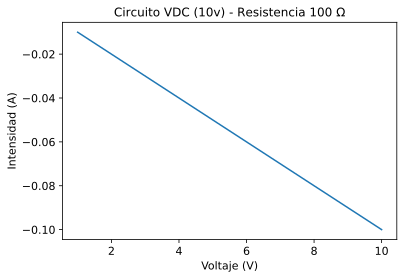

In [28]:
l = ltspice.Ltspice("files\circuito_sencillo.raw")
l.parse()
tiempo = l.get_time()
voltaje = l.get_data('v1')
corriente = l.get_data('I(V1)')

fig, ax = plot.subplots()
ax.set(xlabel='Voltaje (V)', ylabel='Intensidad (A)',
       title='Circuito VDC ($\mathrm{10v}$) - Resistencia $\mathrm{100\ \Omega}$')
ax.plot(voltaje, corriente)
plot.show()

  ## Análisis de circuito con resistencias en serie

 Vamos a resolver (en punto de operación) el siguiente circuito, que consta de 3 resistencias en serie de $\mathrm{3k\Omega}$, $\mathrm{10k\Omega}$ y $\mathrm{5k\Omega}$ respectivamente:

 ![](https://raw.githubusercontent.com/pammacdotnet/spicelab/master/resistencias%20en%20serie.svg?sanitize=true)

 Al igual que antes, grabamos el netlist en disco desde Jupyter con los datos representativos del circuito comentado. Para ello usamos la *palabra mágica* [`%writefile`](https://ipython.readthedocs.io/en/stable/interactive/magics.html#cellmagic-writefile). Más info [aquí](https://ipython.readthedocs.io/en/stable/interactive/magics.html#cellmagic-writefile).

In [29]:
%%writefile "files\resistencias_en_serie.net"
* circuito con tres resistencias en serie
v1 1 0 type=vdc vdc=9
R1 0 2 3k
R2 2 3 10k  
R3 3 1 5k
* análisis del circuito
.op
.end

Writing files\resistencias_en_serie.net


 Haciendo uso de la librería `Ahkab` procesamos el circuito que acabamos de definir.

In [30]:
circuito_y_análisis = ahkab.netlist_parser.parse_circuit('files\\resistencias_en_serie.net')

 El método `ahkab.netlist_parser.parse_circuit()` ha creado una lista en cuya primera posición se ha guardado la lista de componentes y sus conexiones, y en la segunda posición, la listas de análisis que se quieren realizar durante la simulación.

 Extraemos estos datos a sendas variables.

In [31]:
netlist = circuito_y_análisis[0]
análisis_en_netlist = circuito_y_análisis[1]

 Ahora con el método `ahkab.netlist_parser.parse_analysis()` generamos una lista con las operaciones de análisis que se realizaran durante la simulación. Cada elemento de la lista contendrá el tipo de análisis a realizar (dc, tran, etc.) y los parámetros con los que se realizará cada análisis.

In [32]:
lista_de_análisis = ahkab.netlist_parser.parse_analysis(netlist, análisis_en_netlist)
print(lista_de_análisis)

[{'type': 'op', 'guess': True, 'x0': None}]


 Podemos usar lo que hemos definido durante el circuito anterior para añadir el archivo temporal `.tsv` si fuera necesario, aunque ahora no haría falta, puesto que no hemos establecido ningún análisis `.dc` ni `.tran`

In [33]:
for analisis in [d for i, d in enumerate(lista_de_análisis) if "dc" in d.values() or "tran" in d.values()]:
    analisis['outfile'] = files_directory + "simulación_" + analisis['type'] + ".tsv"

 Ya tenemos lo necesario para ejecutar las simulaciones. Esto lo haremos usando el método `.run` de Ahkab

In [34]:
resultados = ahkab.run(netlist, lista_de_análisis)

Starting op analysis:
Calculating guess: skipped. (linear circuit)
Solving...   done.
Solving...   done.
Difference check within margins.
(Voltage: er=0.001, ea=1e-06, Current: er=0.001, ea=1e-09)


 Imprimimos los resultados del análisis `.op`:

In [35]:
print(resultados['op'])

OP simulation results for '* circuito con tres resistencias en serie'(netlist files\resistencias_en_serie.net).
Run on 2020-12-23 19:04:53, data file None.
Variable    Units      Value     Error    %
----------  -------  -------  --------  ---
V1          V         9       -9e-12      0
V2          V         1.5     -1.5e-12    0
V3          V         6.5     -6.5e-12    0
I(V1)       A        -0.0005   0          0


 Los valores `V1`, `V2` y `V3` representan la diferencia de potencial (V) que hay entre los bornes de las conexiones `1`, `2` y `3` definidas en el netlist y masa, que es el borne `0`, es decir, la conexión entre la pila y `R1`:
 >```spice
 v1 1 0 type=vdc vdc=9
 R1 0 2 3k
 R2 2 3 10k
 R3 3 1 5k
 ```

 * `V1` es la diferencia de potencial entre la conexión de la pila con `R3` y masa.
 * `V2` es la diferencia de potencial entre la conexión de `R1` con `R2` y masa.
 * `V3` es la diferencia de potencial entre la conexión de `R2` con `R3` y masa.

 ### **Ejercicio**:

 Comprueba que podemos calcular el *potencial consumido* por la resistencia `R1` y verás que coincide con el del punto `V2` devuelto por Ahkab.

 ### **Respuesta**:

 Huelga decir que la carga de dos resistencias en serie es la suma de sus cargas, por lo que podríamos tratar el circuito como si de dos resistencias en serie se tratara. Una sería `R1` $\mathrm{(3k\Omega)}$ y la otra la suma de `R2`+`R3` $(\mathrm{10k\Omega}+\mathrm{5k\Omega}=\mathrm{15k\Omega})$ y la carga total sería `R1`+`R2`+`R3` $(\mathrm{3k\Omega}+\mathrm{10k\Omega}+\mathrm{5k\Omega}=\mathrm{18k\Omega})$

 Si calculamos manualmente la corriente, sabiendo que tenemos una diferencia de potencial de $\mathrm{9v}$ a los extremos de la pila, tenemos que:
 $$\mathrm{V}=\mathrm{R}\cdot\mathrm{I}$$
 $$\mathrm{I}=\frac{\mathrm{V}}{\mathrm{R}}=\frac{\mathrm{9v}}{\mathrm{18k\Omega}}=\mathrm{0.5\ mA}$$
 Que se corresponde con los $\mathrm{0.0005\ A}$ que nos ha devuelto `Ahkab` para `I(V1)`

 Puesto que las resistencias están en serie, el flujo de electrones en cada resistencia debe de ser el mismo, en concreto el equivalente a $\mathrm{0.5\ mA}$. Por tanto podemos calcular la caída de potencial en cada resistencia.

 $$\mathrm{V_1}=\mathrm{R_1}\cdot\mathrm{I}=\mathrm{3k\Omega}\cdot\mathrm{0.5\ mA}=\mathrm{1.5v}$$
 $$\mathrm{V_2}=\mathrm{R_2}\cdot\mathrm{I}=\mathrm{10k\Omega}\cdot\mathrm{0.5\ mA}=\mathrm{5v}$$
 $$\mathrm{V_3}=\mathrm{R_3}\cdot\mathrm{I}=\mathrm{5k\Omega}\cdot\mathrm{0.5\ mA}=\mathrm{2.5v}$$

 Como se puede observar, la suma de las caídas de potencial es exactamente la diferencia de potencial en los extremos de la pila, que también son los extremos de las tres resistencias.
 $$\mathrm{V}=\mathrm{V_1}+\mathrm{V_2}+\mathrm{V_3}=\mathrm{1.5v}+\mathrm{5v}+\mathrm{2.5v}=\mathrm{9v}$$

 #### Comprobemos si coincide lo que dice `Ahkab` y `V2` es $\mathrm{1.5v}$.

 La suma de las caídas de potencial de las resistencias `R2`+`R3` es $\mathrm{5v}+\mathrm{2.5v}=\mathrm{7.5v}$.

 ### ¿Porque no coincide?
 Si nos fijamos bien en el netlist:
 ```spice
 v1 1 0 type=vdc vdc=9
 R1 0 2 3k
 R2 2 3 10k
 R3 3 1 5k
 ```

 Vemos que el orden en el que se han definido las resistencias es este:

 `+Vcc` )---**1**---( `R3` )---**3**---( `R2` )---**2**---( `R1` )---**0**---( `Gnd`

 Aquí el borne 2 tiene entre él y masa únicamente a `R1`. Según nuestros cálculos la caída de potencial en `R1` es de $=\mathrm{1.5v}$ y sí que coincide con lo que dice `Ahkab` para `V2`, que es $\mathrm{1.5v}$

 ### Entonces, ¿Dónde está el error?
 Si observamos el esquema:

  ![](https://raw.githubusercontent.com/pammacdotnet/spicelab/master/resistencias%20en%20serie.svg?sanitize=true)

 Primer fallo. No coincide el orden de las resistencias con el del netlist. El orden sería este:

  `+Vcc` )---**1**---( `R1` )---**3**---( `R2` )---**2**---( `R3` )---**0**---( `Gnd`

 Pero además, para el cálculo hemos interpretado que entre el borne 2 y masa había dos resistencias, por lo que el orden correcto de las resistencias y de las conexiones para que se ajuste a los cálculos sería este:

  `+Vcc` )---**1**---( `R1` )---**2**---( `R2` )---**3**---( `R3` )---**0**---( `Gnd`

 ### Vamos a comprobarlo

 Volvemos a definir el netlist, esta vez para el orden coincida con los cálculos que hemos realizado.

 `v1` )---**1**---( `R1` )---**2**---( `R2` )---**3**---( `R3` )---**0**---( `v1`
 >```spice
 v1 1 0 type=vdc vdc=9
 R1 1 2 3k
 R2 2 3 10k
 R3 3 0 5k
 ```

In [36]:
%%writefile "files\resistencias_en_serie.net"
* circuito con tres resistencias en serie
v1 1 0 type=vdc vdc=9 
R1 1 2 3k  
R2 2 3 10k    
R3 3 0 5k  
* análisis del circuito
.op
.end

Overwriting files\resistencias_en_serie.net


 Volvemos a procesar el circuito con `Ahkab` y extraemos los datos.

In [37]:
# Procesar circuito
circuito_y_análisis = ahkab.netlist_parser.parse_circuit('files\\resistencias_en_serie.net')
# Separar datos netlist y simulaciones
netlist = circuito_y_análisis[0]
análisis_en_netlist = circuito_y_análisis[1]
# Extraer datos de simulaciones
lista_de_análisis = ahkab.netlist_parser.parse_analysis(netlist, análisis_en_netlist)
# Establecer condiciones óptimas para los análisis `.dc` y/o `.tran` si lo hay.
for analisis in [d for i, d in enumerate(lista_de_análisis) if "dc" in d.values() or "tran" in d.values()]:
    analisis['outfile'] = files_directory + "simulación_" + analisis['type'] + ".tsv"

 Ejecutamos las simulaciones para el nuevo circuito y mostramos el resultado de la simulación `.op`.

In [38]:
resultados = ahkab.run(netlist, lista_de_análisis)
print(resultados['op'])

Starting op analysis:
Calculating guess: skipped. (linear circuit)
Solving...   done.
Solving...   done.
Difference check within margins.
(Voltage: er=0.001, ea=1e-06, Current: er=0.001, ea=1e-09)
OP simulation results for '* circuito con tres resistencias en serie'(netlist files\resistencias_en_serie.net).
Run on 2020-12-23 19:04:55, data file None.
Variable    Units      Value     Error    %
----------  -------  -------  --------  ---
V1          V         9       -9e-12      0
V2          V         7.5     -7.5e-12    0
V3          V         2.5     -2.5e-12    0
I(V1)       A        -0.0005   0          0


 ### FANTÁSTICO !!!
 Ahora sí coinciden los resultados. Podemos ver que `V2` corresponde con la caída calculada. Además, también V3 coincide con la caída calculada para la R3 que era de $\mathrm{2.5v}$

 ### Comprobamos con Sympy
 Comprobamos con Sympy que para la corriente obtenida de la simulación, una resistencia de $\mathrm{3k\Omega}$ provoca una caída de potencial de $\mathrm{1.5v}$

In [39]:
r1 = 3E3*ohms
int=resultados['op']['I(V1)']
intensidad_ahkab = resultados['op']['I(V1)'][0][0]*amperes
v2 = convert_to(intensidad_ahkab*r1, [volts])
v2

-1.5*volt

 ### **Pregunta**:

 > Reproduce el resto de los valores anteriores de manera *manual* mediante Sympy (es decir, aplicando la ley de Ohm, pero con un *toque computacional*). Te pongo aquí un ejemplo del que puedes partir… En él sólo calculo la corriente que circula por el circuito (sí, justo la que antes Ahkab ha devuelto de manera automática). Para ello necesito previamente computar la resistencia total (`r_total`). Faltarían el resto de resultados y convertirlos a unidades más *vistosas* (mediante la orden `convert_to` y `.n()`).

In [40]:
v1 = 9*volts
r1 = 3*kilo*ohms
r2 = 10*kilo*ohms
r3 = 5*kilo*ohms
r_total = r1 + r2 + r3
intensidad = symbols('i')
ley_ohm = Eq(v1, intensidad*r_total)
solucion_para_intensidad = solve(ley_ohm, intensidad)
convert_to(solucion_para_intensidad[0], [amperes]).n(2)

0.0005*ampere

 ### **Respuesta**:
 Supondremos el orden de las resistencias igual que el del circuito del esquema, es decir, igual que el de los cálculos que hemos hecho a mano.

In [41]:
print("Voltaje entre extremos de R1:")
voltaje = symbols('v')
ley_ohm = Eq(voltaje, solucion_para_intensidad[0]*r1)
solucion_para_voltaje_R1 = solve(ley_ohm, voltaje)
convert_to(solucion_para_voltaje_R1[0], [volts]).n(2)

Voltaje entre extremos de R1:


1.5*volt

In [42]:
print("Voltaje entre extremos de R2:")
voltaje = symbols('v')
ley_ohm = Eq(voltaje, solucion_para_intensidad[0]*r2)
solucion_para_voltaje_R2 = solve(ley_ohm, voltaje)
convert_to(solucion_para_voltaje_R2[0], [volts]).n(2)

Voltaje entre extremos de R2:


5.0*volt

In [43]:
print("Voltaje entre extremos de R3:")
voltaje = symbols('v')
ley_ohm = Eq(voltaje, solucion_para_intensidad[0]*r3)
solucion_para_voltaje_R3 = solve(ley_ohm, voltaje)
convert_to(solucion_para_voltaje_R3[0], [volts]).n(2)

Voltaje entre extremos de R3:


2.5*volt

In [44]:
print("Voltaje entre conexión R1-R2 y masa:")
voltaje = symbols('v')
ley_ohm = Eq(voltaje, solucion_para_intensidad[0]*(r2+r3))
solucion_para_voltaje_R2_masa = solve(ley_ohm, voltaje)
convert_to(solucion_para_voltaje_R2_masa[0], [volts]).n(2)

Voltaje entre conexión R1-R2 y masa:


7.5*volt

In [45]:
print("Voltaje entre VCC y conexión R2-R3:")
voltaje = symbols('v')
ley_ohm = Eq(voltaje, solucion_para_intensidad[0]*(r1+r2))
solucion_para_voltaje_VCC_R3 = solve(ley_ohm, voltaje)
convert_to(solucion_para_voltaje_VCC_R3[0], [volts]).n(2)

Voltaje entre VCC y conexión R2-R3:


6.5*volt

 ### **Pregunta**:
 > Demuestra que se cumple la Ley de Kirchhoff de la energía en un circuito, es decir, que la suma de la energía suministrada por las fuentes (pilas) es igual a la consumida por las resistencias. Realiza la operación con Sympy.

 > $$
 \sum_i^N V_{\text{fuentes}} = \sum_j^M V_{\text{consumido en resistencias}}
 > $$
 > Ten en cuenta que en este caso sólo hay una fuente.

 ### **Respuesta**:
 Vaya, parece que nos adelantado a este punto, la respuesta a esto está en el apartado anterior. Podemos comprobar que la suma de los voltajes en cada resistencia es igual al voltaje suministrado por la pila.

In [46]:
print("Suma de los voltajes de cada resistencia:")
voltaje_resistencias = solucion_para_voltaje_R1[0] + solucion_para_voltaje_R2[0] + solucion_para_voltaje_R3[0]
convert_to(voltaje_resistencias, [volts]).n(2)

Suma de los voltajes de cada resistencia:


9.0*volt

 ## Análisis `.op` de circuitos con resistencias en paralelo

 Vamos a complicar un poco el trabajo añadiendo elementos en paralelo.

  > **Pregunta**: realiza los análisis `.op` de los siguientes circuitos.
  Para ello crea un netlist separado para cada uno donde queden correctamente descritos
  junto con la simulación (`.op`). Comenta los resultados que devuelve Ahkab (no imprimas los resultados de las simulaciones *sin más*).

  ![](https://raw.githubusercontent.com/pammacdotnet/spicelab/master/resistencias%20en%20paralelo.svg?sanitize=true)

  Aquí tienes el análisis del primer circuito, para que sirva de ejemplo:

 ### **Análisis del primer circuito**

  ![](https://raw.githubusercontent.com/tikissmikiss/Laboratorio-LTspice/master/resource/Circuito_paralelo_1_lab_fisica.svg?sanitize=true)

 Definimos el netlist del primer circuito paralelo.

In [47]:
%%writefile "files\resistencias_en_paralelo_1.cir"
* resistencias en paralelo
vdd 0 1 vdc=12 type=vdc
r2 1 2 1k
r3 2 3 220
r4 3 0 1.5k
r5 2 0 470
.op
.end

Writing files\resistencias_en_paralelo_1.cir


 Procesamos el circuito con `Ahkab` y extraemos los datos.

In [48]:
# Procesar circuito
circuito_y_análisis = ahkab.netlist_parser.parse_circuit('files\\resistencias_en_paralelo_1.cir')
# Separar datos netlist y simulaciones
netlist = circuito_y_análisis[0]
análisis_en_netlist = circuito_y_análisis[1]
# Extraer datos de simulaciones
lista_de_análisis = ahkab.netlist_parser.parse_analysis(netlist, análisis_en_netlist)
# Establecer condiciones óptimas para los análisis `.dc` y/o `.tran` si lo hay.
for analisis in [d for i, d in enumerate(lista_de_análisis) if "dc" in d.values() or "tran" in d.values()]:
    analisis['outfile'] = files_directory + "simulación_" + analisis['type'] + ".tsv"

  Ejecutamos la simulación

In [49]:
resultados = ahkab.run(netlist, lista_de_análisis)

Starting op analysis:
Calculating guess: skipped. (linear circuit)
Solving...   done.
Solving...   done.
Difference check within margins.
(Voltage: er=0.001, ea=1e-06, Current: er=0.001, ea=1e-09)


 Imprimimos los resultados del análisis `.op`. Como puedes comprobar, Ahkab sólo reporta la intensidad de corriente en las ramas en las que hay una pila (en este caso, la rama donde está la pila `VDD`).

In [50]:
print(resultados['op'])

OP simulation results for '* resistencias en paralelo'(netlist files\resistencias_en_paralelo_1.cir).
Run on 2020-12-23 19:05:00, data file None.
Variable    Units           Value        Error    %
----------  -------  ------------  -----------  ---
V1          V        -12           1.2e-11        0
V2          V         -3.23533     3.23532e-12    0
V3          V         -2.8215      2.82151e-12    0
I(VDD)      A         -0.00876467  0              0


 ### **Pregunta:**

 > Inserta dos *pilas virtuales* de 0 voltios en el resto de ramas del circuito (`Vdummy1` en la rama donde está `R5` y `Vdummy2` en la rama donde está `R3` y `R4`) para que Ahkab nos imprima también la corriente en las mismas. Es muy parecido al tercer circuito que tienes que resolver, donde `V1`, `V2` y `V3` tienen cero voltios. Estas *pilas nulas* son, a todos los efectos, *simples cables*. Una vez que ya tienes las corrientes en todas las ramas, comprueba que se cumple la Ley de Kirchhoff para las corrientes:

 > $$I_{\text{entrante}} = \sum_i^{N} I_{\text{salientes}}$$

 > Repite lo mismo para los otros dos circuitos. Realiza además los cálculos con Sympy (recalcula los mismos voltajes que devuelve Ahkab a partir de la corriente que sí te devuelve la simulación) y cuidando de no olvidar las unidades. Recuerda que el objeto `resultados` alberga toda la información que necesitas de manera indexada. Ya han aparecido un ejemplo más arriba. Es decir: no *copies* los números *a mano*, trabaja de manera informáticamente elegante (usando la variable `resultados`).

 ### **Respuesta**
 Definimos el netlist con las dos pilas de $\mathrm{0v}$

In [51]:
%%writefile "files\resistencias_en_paralelo_1.cir"
* resistencias en paralelo
vdd 1 0 vdc=12 type=vdc
Vdummy1 4 0 vdc=0 type=vdc
Vdummy2 5 0 vdc=0 type=vdc
r2 1 2 1k
r3 2 3 220
r4 3 5 1.5k
r5 2 4 470
.op
.end

Overwriting files\resistencias_en_paralelo_1.cir


 Procesamos el circuito con `Ahkab` y extraemos los datos.

In [52]:
# Procesar circuito
circuito_y_análisis = ahkab.netlist_parser.parse_circuit('files\\resistencias_en_paralelo_1.cir')
# Separar datos netlist y simulaciones
netlist = circuito_y_análisis[0]
análisis_en_netlist = circuito_y_análisis[1]
# Extraer datos de simulaciones
lista_de_análisis = ahkab.netlist_parser.parse_analysis(netlist, análisis_en_netlist)
# Establecer condiciones óptimas para los análisis `.dc` y/o `.tran` si lo hay.
for analisis in [d for i, d in enumerate(lista_de_análisis) if "dc" in d.values() or "tran" in d.values()]:
    analisis['outfile'] = files_directory + "simulación_" + analisis['type'] + ".tsv"

  Ejecutamos la simulación

In [53]:
resultados = ahkab.run(netlist, lista_de_análisis)

Starting op analysis:
Calculating guess: skipped. (linear circuit)
Solving...   done.
Solving...   done.
Difference check within margins.
(Voltage: er=0.001, ea=1e-06, Current: er=0.001, ea=1e-09)


 Imprimimos los resultados del análisis `.op`.

In [54]:
print(resultados['op'])

OP simulation results for '* resistencias en paralelo'(netlist files\resistencias_en_paralelo_1.cir).
Run on 2020-12-23 19:05:03, data file None.
Variable    Units          Value         Error    %
----------  -------  -----------  ------------  ---
V1          V        12           -1.2e-11        0
V4          V         0           -8.67362e-19    0
V5          V         0            0              0
V2          V         3.23533     -3.23532e-12    0
V3          V         2.8215      -2.82151e-12    0
I(VDD)      A        -0.00876467   0              0
I(VDUMMY1)  A         0.00688367   0              0
I(VDUMMY2)  A         0.001881     0              0


 Como podemos ver la suma de las corrientes de las pilas dummy es igual a la corriente total. Comprobémoslos.

 La corriente total es:

In [55]:
intensidad = -resultados['op'].results._dict['I(VDD)']*amperes
convert_to(intensidad, [amperes]).n(5)

0.0087647*ampere

 La suma de las corrientes de la pilas dummy es:

In [56]:
intensidad_dummy1 = resultados['op'].results._dict['I(VDUMMY1)']*amperes
intensidad_dummy2 = resultados['op'].results._dict['I(VDUMMY2)']*amperes
convert_to(intensidad_dummy1+intensidad_dummy2, [amperes]).n(5)

0.0087647*ampere

 GENIAL !!! Se cumple la Ley de Kirchhoff

 ### Comprobemos el resultado de `Ahkab` con Sympy
 Ahora tenemos resistencias en paralelo, por lo que ya no podemos sumar sus resistencias para averiguar la resistencia total del circuito.

 ¿Como afecta la carga resistiva de dos resistencias en paralelo a la carga total?

 Antes de responder a esta pregunta calculemos la resistencia total con los datos de los que disponemos.

 Nótese que no existen resistencias negativas, ya que son componentes pasivos. Puesto que `Ahkab` nos está dando la corriente en negativo, le invertimos el signo para que la resistencia resulte positiva.

In [57]:
v1 = 12*volts
r2 = 1*kilo*ohms
r3 = 220*ohms
r4 = 1.5*kilo*ohms
r5 = 470*ohms
intensidad = -resultados['op'].results._dict['I(VDD)']*amperes 
resistencia = symbols('r')
ley_ohm = Eq(v1, intensidad*resistencia)
resistencia_total = solve(ley_ohm, resistencia)
convert_to(resistencia_total[0], [ohms]).n(5)

1369.1*ohm

 Como ya sabemos, la resistencia total de cargas en serie es la suma de sus resistencias. Ahora que conocemos la resistencia total, la resistencia equivalente de las dos mallas formadas por `R3`, `R4` y `R5`, solo puede ser la resistencia total menos la resistencia de `R2`

In [58]:
r_subcircuito = resistencia_total[0] - r2
convert_to(r_subcircuito, [ohms]).n(5)

369.13*ohm

 Gracias a `Ahkab` conocemos la corriente total y también el voltaje en el borne 2. Comprobemos con estos datos que la resistencia que acabamos de obtener es correcta.

In [59]:
v = resultados['op'].results._dict['V2']*volts
i = -resultados['op'].results._dict['I(VDD)']*amperes 
resistencia = symbols('r')
ley_ohm = Eq(v, i*resistencia)
r_subcircuito = solve(ley_ohm, resistencia)
convert_to(r_subcircuito[0], [ohms]).n(5)

369.13*ohm

 Conocemos la resistencia de cada maya, ya que una es `R5` y la otra `R3`+`R4`. Esto es $R_{m1}=\mathrm{470\ \Omega}$ y $R_{m2}=\mathrm{1720\ \Omega}$, pero la resistencia equivalente es inferior a la de cualquiera de las dos mallas. ¿Porqué? ¿Qué está pasando?

 Veámoslo con números más redondos. Supongamos que una pila de $\mathrm{10\ v}$ aporta una corriente de $\mathrm{1\ A}$ a un circuito con dos cargas en paralelo, de las que no conocemos sus resistencias, pero sabemos que son iguales.

 La resistencia equivalente sería $\frac{\mathrm{10\ v}}{\mathrm{1\ A}}=\mathrm{10\ \Omega}$

 Para que se cumpla la Ley de Kirchhoff, por cada rama deben circular $\mathrm{0.5\ A}$, por tanto la resistencias serán de $\mathrm{20\ \Omega}$

 Vaya!!! la resistencia equivalente es justo la mitad del valor de las resistencias si estas son iguales. Esto es porque para que se cumpla la Ley de Kirchhoff, el flujo de electrones se tiene que repartir entre cada malla proporcionalmente a su resistencia, y como ya hemos visto por la ley de Ohm, esto sucede con una proporcionalidad lineal. Por lo que la inversa de la resistencia equivalente será igual a la suma de las inversas de cada malla.

 Comprobemos esto con los datos que tenemos del circuito.

In [60]:
inv_malla1 = 1/r5
inv_malla2 = 1/(r3+r4)
equiv = symbols('equiv')
equiv = solve(1/equiv-inv_malla1-inv_malla2, equiv)
convert_to(equiv[0], [ohms]).n(5)

369.13*ohm

 Nos falta por comprobar que los voltajes de cada nodo devueltos por `Ahkab` son correctos.
 #### Voltaje en el nodo 2 según `Ahkab`:")

In [61]:
resultados['op'].results._dict['V2']*volts

3.23532550693703*volt

 #### Comprobamos el voltaje en el nodo 2 con Sympy:")

In [62]:
print("Voltaje en el nodo 2:")
v = symbols('v')
intensidad = -resultados['op'].results._dict['I(VDD)']*amperes 
ley_ohm = Eq(v, intensidad*equiv[0])
voltaje_V2 = solve(ley_ohm, v)
convert_to(voltaje_V2[0], [volts]).n(3)

Voltaje en el nodo 2:


3.24*volt

 #### Voltaje en el nodo 3 según `Ahkab`:")

In [63]:
resultados['op'].results._dict['V3']*volts

2.82150480256136*volt

 #### Comprobamos el voltaje en el nodo 3 con Sympy:")

In [64]:
print("Voltaje en el nodo 3:")
v = symbols('v')
ley_ohm = Eq(v, intensidad_dummy2*r4)
voltaje_V3 = solve(ley_ohm, v)
convert_to(voltaje_V3[0], [volts]).n(3)

Voltaje en el nodo 3:


2.82*volt

 ### **Análisis del segundo circuito**

  ![](https://raw.githubusercontent.com/tikissmikiss/Laboratorio-LTspice/master/resource/Circuito_paralelo_2_lab_fisica.svg?sanitize=true)

 Definimos el netlist del segundo circuito paralelo. Nos adelantamos y colocamos una pila de $\mathrm{0\ v}$ en la malla de las tres resistencias en serie.

In [65]:
%%writefile "files\resistencias_en_paralelo_2.cir"
* resistencias en paralelo
v1 1 0 vdc=9 type=vdc
v2 4 0 vdc=1.5 type=vdc
vdummy 6 0 vdc=0 type=vdc
r1 1 2 47
r2 2 3 220
r3 2 4 180
r4 3 5 1k
r5 5 6 560
.op
.end

Writing files\resistencias_en_paralelo_2.cir


 Procesamos el circuito con `Ahkab` y extraemos los datos.

In [66]:
# Procesar circuito
circuito_y_análisis = ahkab.netlist_parser.parse_circuit('files\\resistencias_en_paralelo_2.cir')
# Separar datos netlist y simulaciones
netlist = circuito_y_análisis[0]
análisis_en_netlist = circuito_y_análisis[1]
# Extraer datos de simulaciones
lista_de_análisis = ahkab.netlist_parser.parse_analysis(netlist, análisis_en_netlist)
# Establecer condiciones óptimas para los análisis `.dc` y/o `.tran` si lo hay.
for analisis in [d for i, d in enumerate(lista_de_análisis) if "dc" in d.values() or "tran" in d.values()]:
    analisis['outfile'] = files_directory + "simulación_" + analisis['type'] + ".tsv"

  Ejecutamos la simulación

In [67]:
resultados = ahkab.run(netlist, lista_de_análisis)

Starting op analysis:
Calculating guess: skipped. (linear circuit)
Solving...   done.
Solving...   done.
Difference check within margins.
(Voltage: er=0.001, ea=1e-06, Current: er=0.001, ea=1e-09)


 Imprimimos los resultados del análisis `.op`.

In [68]:
print(resultados['op'])

OP simulation results for '* resistencias en paralelo'(netlist files\resistencias_en_paralelo_2.cir).
Run on 2020-12-23 19:05:11, data file None.
Variable    Units          Value         Error    %
----------  -------  -----------  ------------  ---
V1          V         9           -8.99997e-12    0
V4          V         1.5         -1.5e-12        0
V6          V         0           -8.67362e-19    0
V2          V         7.29441     -7.29442e-12    0
V3          V         6.39285     -6.39285e-12    0
V5          V         2.29487     -2.29487e-12    0
I(V1)       A        -0.0362891    0              0
I(V2)       A         0.0321912    0              0
I(VDUMMY)   A         0.00409798   0              0


 Comprobamos que se cumple la Ley de Kirchhoff para las corrientes

 La corriente total es:

In [69]:
intensidad_total = -resultados['op'].results._dict['I(V1)']*amperes
convert_to(intensidad_total, [amperes]).n(5)

0.036289*ampere

 La suma de las corrientes de las mallas es:

In [70]:
intensidad_malla1 = resultados['op'].results._dict['I(V2)']*amperes
intensidad_malla2 = resultados['op'].results._dict['I(VDUMMY)']*amperes
convert_to(intensidad_malla1+intensidad_malla2, [amperes]).n(5)

0.036289*ampere

 GENIAL !!! Se cumple la Ley de Kirchhoff

 ### Comprobemos los resultados de `Ahkab` con Sympy

 Inicializamos variables:

In [71]:
v1 = 9*volts
v2 = 1.5*volts
r1 = 47*ohms
r2 = 220*ohms
r3 = 180*ohms
r4 = 1*kilo*ohms
r5 = 560*ohms

 Puesto que no sabemos cómo está afectando la pila que hay en serie con `R3`, es más sencillo calcular la tensión en el nodo 2, restando a `v1` la diferencia de potencial entre extremos de `R1`.

 #### La diferencia de potencial en V2 según `Ahkab` es:

In [72]:
resultados['op'].results._dict['V2']*volts

7.29440996800155*volt

 #### Comprobamos diferencia de potencial en V2 con Sympy:

In [73]:
v = symbols('v')
ley_ohm = Eq(v, intensidad_total*r1)
# calcular la tensión entre extremos de r1
voltaje_R1 = solve(ley_ohm, v)
voltaje_V2 = v1-voltaje_R1[0]
convert_to(voltaje_V2, [volts]).n(3)

7.29*volt

 Para calcular la diferencia de potencial en V3 aplicamos la *Ley de Ohm* para la corriente devuelta por `Ahkab` en la pila dummy y la suma de las resistencias `R4` y `R5`.

 #### La diferencia de potencial en V3 según `Ahkab` es:

In [74]:
resultados['op'].results._dict['V3']*volts

6.39285367982158*volt

 #### Comprobamos diferencia de potencial en V3 con Sympy:

In [75]:
v = symbols('v')
ley_ohm = Eq(v, intensidad_malla2*(r4+r5))
voltaje_V3 = solve(ley_ohm, v)
convert_to(voltaje_V3[0], [volts]).n(3)


6.39*volt

 La diferencia de potencial en V4 es igual a la de la pila `V2`.

 #### La diferencia de potencial en V3 según `Ahkab` es:

In [76]:
resultados['op'].results._dict['V4']*volts

1.5*volt

 #### La diferencia de potencial en V4 con Sympy:

In [77]:
voltaje_V4 = v2
convert_to(voltaje_V4, [volts]).n(3)

1.5*volt

 Para calcular la diferencia de potencial en V5 aplicamos la *Ley de Ohm* para la corriente devuelta por `Ahkab` en la pila dummy y la resistencias `R5`.

 #### La diferencia de potencial en V5 según `Ahkab` es:

In [78]:
resultados['op'].results._dict['V5']*volts

2.29487055173082*volt

 #### Comprobamos diferencia de potencial en V5 con Sympy:

In [79]:
print("La diferencia de potencial en V5 es:")
v = symbols('v')
ley_ohm = Eq(v, intensidad_malla2*r5)
voltaje_V5 = solve(ley_ohm, v)
convert_to(voltaje_V5[0], [volts]).n(3)

La diferencia de potencial en V5 es:


2.29*volt

 ### **Análisis del tercer circuito**

  ![](https://raw.githubusercontent.com/tikissmikiss/Laboratorio-LTspice/master/resource/Circuito_paralelo_3_lab_fisica.svg?sanitize=true)

 Definimos el netlist del tercer circuito paralelo.

In [80]:
%%writefile "files\resistencias_en_paralelo_3.cir"
* resistencias en paralelo
v 1 0 vdc=9 type=vdc
v1 1 2 vdc=0 type=vdc
v2 1 3 vdc=0 type=vdc
v3 1 4 vdc=0 type=vdc
r1 2 0 10k
r2 3 0 2k
r3 4 0 1k
.op
.end

Writing files\resistencias_en_paralelo_3.cir


 Procesamos el circuito con `Ahkab` y extraemos los datos.

In [81]:
# Procesar circuito
circuito_y_análisis = ahkab.netlist_parser.parse_circuit('files\\resistencias_en_paralelo_3.cir')
# Separar datos netlist y simulaciones
netlist = circuito_y_análisis[0]
análisis_en_netlist = circuito_y_análisis[1]
# Extraer datos de simulaciones
lista_de_análisis = ahkab.netlist_parser.parse_analysis(netlist, análisis_en_netlist)
# Establecer condiciones óptimas para los análisis `.dc` y/o `.tran` si lo hay.
for analisis in [d for i, d in enumerate(lista_de_análisis) if "dc" in d.values() or "tran" in d.values()]:
    analisis['outfile'] = files_directory + "simulación_" + analisis['type'] + ".tsv"

  Ejecutamos la simulación

In [82]:
resultados = ahkab.run(netlist, lista_de_análisis)

Starting op analysis:
Calculating guess: skipped. (linear circuit)
Solving...   done.
Solving...   done.
Difference check within margins.
(Voltage: er=0.001, ea=1e-06, Current: er=0.001, ea=1e-09)


 Imprimimos los resultados del análisis `.op`.

In [83]:
print(resultados['op'])

OP simulation results for '* resistencias en paralelo'(netlist files\resistencias_en_paralelo_3.cir).
Run on 2020-12-23 19:05:19, data file None.
Variable    Units      Value    Error    %
----------  -------  -------  -------  ---
V1          V         9        -9e-12    0
V2          V         9        -9e-12    0
V3          V         9        -9e-12    0
V4          V         9        -9e-12    0
I(V)        A        -0.0144    0        0
I(V1)       A         0.0009    0        0
I(V2)       A         0.0045    0        0
I(V3)       A         0.009     0        0


 Comprobamos que se cumple la Ley de Kirchhoff para las corrientes

 La corriente total es:

In [84]:
intensidad_total = -resultados['op'].results._dict['I(V)']*amperes
convert_to(intensidad_total, [amperes]).n(5)

0.0144*ampere

 La suma de las corrientes de las mallas es:

In [85]:
intensidad_malla1 = resultados['op'].results._dict['I(V1)']*amperes
intensidad_malla2 = resultados['op'].results._dict['I(V2)']*amperes
intensidad_malla3 = resultados['op'].results._dict['I(V3)']*amperes
convert_to(intensidad_malla1+intensidad_malla2+intensidad_malla3, [amperes]).n(5)

0.0144*ampere

 GENIAL !!! Se cumple la Ley de Kirchhoff

 ### Comprobemos los resultados de `Ahkab` con Sympy

 Inicializamos variables:

In [86]:
v = 9*volts
r1 = 10*kilo*ohms
r2 = 2*kilo*ohms
r3 = 1*kilo*ohms

 Calculemos la resistencia equivalente de las 3 malla del modo que hemos visto en el primer circuito.
 $$ \frac{ 1 }{ R_{eqv} }=\sum_i^{n} \frac{ 1 }{ R_i } $$

In [87]:
inv_r1 = 1/r1
inv_r2 = 1/r2
inv_r3 = 1/r3
equiv = symbols('equiv')
equiv = solve(1/equiv-inv_r1-inv_r2-inv_r3, equiv)
convert_to(equiv[0], [ohms]).n(5)

625.0*ohm

 Comprobemos si esto es cierto usando la Ley de Ohm. Calculamos la resistencia total usando la tensión conocida de la pila y la corriente devuelta por `Ahkab`.

In [88]:
equiv = symbols('equiv')
ley_ohm = Eq(v, intensidad_total*equiv)
equiv = solve(1/equiv-inv_r1-inv_r2-inv_r3, equiv)
convert_to(equiv[0], [ohms]).n(5)

625.0*ohm

 Perfecto coinciden !!!

 Para este circuito, puesto que todas las resistencias están en paralelo, no tiene mucho sentido comprobar los voltajes de las resistencias, puesto que para todas ellas va a ser el mismo que el de la pila. Por lo que, en este caso, comprobaremos que `Ahkab` nos ha devuelto las corrientes de forma correcta.

  #### La corriente que pasa por `R1` según `Ahkab` es:

In [89]:
intensidad_malla1

0.0009*ampere

 #### Comprobamos la corriente que pasa por `R1` con Sympy:

In [90]:
i = symbols('i')
ley_ohm = Eq(v, i*r1)
i_R1 = solve(ley_ohm, i)
convert_to(i_R1[0], [amperes]).n(5)

0.0009*ampere

  #### La corriente que pasa por `R2` según `Ahkab` es:

In [91]:
intensidad_malla2

0.0045*ampere

 #### Comprobamos la corriente que pasa por `R2` con Sympy:

In [92]:
i = symbols('i')
ley_ohm = Eq(v, i*r2)
i_R2 = solve(ley_ohm, i)
convert_to(i_R2[0], [amperes]).n(5)

0.0045*ampere

  #### La corriente que pasa por `R3` según `Ahkab` es:

In [93]:
intensidad_malla2

0.0045*ampere

 #### Comprobamos la corriente que pasa por `R3` con Sympy:

In [94]:
i = symbols('i')
ley_ohm = Eq(v, i*r3)
i_R3 = solve(ley_ohm, i)
convert_to(i_R3[0], [amperes]).n(5)

0.009*ampere

  # Circuitos en DC que evolucionan con el tiempo

  ## Carga de un condensador
  Vamos a ver qué le pasa a un circuito de corriente continua cuando tiene un condensador
  en serie.

  ![](https://raw.githubusercontent.com/pammacdotnet/spicelab/master/condensador%20en%20continua.svg?sanitize=true)

  Al igual que antes, primero guardamos el circuito en un netlist externo:

In [95]:
%%writefile "files\condensador_en_continua.ckt"
* Carga condensador
v1 1 0 type=vdc vdc=6
r1 1 2 1k
c1 2 0 1m ic=0
.op
.tran tstep=0.1 tstop=8 uic=0
.end

Writing files\condensador_en_continua.ckt


 > **Pregunta:** ¿qué significa el parámetro `ic=0`?

 **Respuesta:**

 #### ¿qué significa el parámetro `ic=0`?

  La directiva ic permite especificar las condiciones iniciales para el análisis transitorio.
 Fuente: *[IC set initial conditions](http://ltwiki.org/index.php?title=IC_set_initial_conditions)*

 #### ¿qué perseguimos con un análisis de tipo `.tran`?
 Una de las cualidades más interesantes de los condensadores para la electrónica, es que se oponen a los cambios bruscos tensión. Esta cualidad combinada con la de las bobinas, las cuales se oponen a los cambios bruscos de corriente, los convierten en componentes ideales para usarlos como filtros.
 Que se opongan a los cambios de voltaje no significa que lo impidan, lo que sucede es que cuando se da un cambio abrupto de potencial, un condensador aumenta el tiempo que transcurre desde el estado de potencial inicial hasta que se alcanza el nuevo estado de potencial. Esto sucede tanto cuando el cambio de potencial se incrementa o se disminuye. Y el tiempo necesario depende de la capacidad del condensador que en el S.I. se expresa en *faradios* y su símbolo es $\mathrm{F}$.

 Lo comentado implica que el estado del circuito va a cambiar a lo largo del tiempo cuando se dé un cambio de potencial y el análisis del tipo `.tran` nos va a permitir simular justamente eso. Lo configuraremos de modo que se reproduzca un cambio de potencial y capturaremos la evolución del circuito en el tiempo.

 ### Procesamos el circuito con `Ahkab` y extraemos los datos.

In [96]:
# Procesar circuito
circuito_y_análisis = ahkab.netlist_parser.parse_circuit("files\condensador_en_continua.ckt")
# Separar datos netlist y simulaciones
netlist = circuito_y_análisis[0]
análisis_en_netlist = circuito_y_análisis[1]
# Extraer datos de simulaciones
lista_de_análisis = ahkab.netlist_parser.parse_analysis(netlist, análisis_en_netlist)
# Establecer condiciones óptimas para los análisis `.dc` y/o `.tran` si lo hay.
for análisis in [d for i, d in enumerate(lista_de_análisis) if "dc" in d.values() or "tran" in d.values()]:
    análisis['outfile'] = files_directory + "simulación_" + análisis['type'] + ".tsv"

  Ejecutamos la simulación

In [97]:
resultados = ahkab.run(netlist, lista_de_análisis)

Starting op analysis:
Calculating guess: skipped. (linear circuit)
Solving...   done.
Solving...   done.
Difference check within margins.
(Voltage: er=0.001, ea=1e-06, Current: er=0.001, ea=1e-09)
Starting transient analysis: 
Selected method: TRAP
Solving...  done.
Average time step: 0.0869565


 Imprimir los resultados de los análisis.

In [98]:
print(resultados['op'])

OP simulation results for '* carga condensador'(netlist files\condensador_en_continua.ckt).
Run on 2020-12-23 19:05:27, data file None.
Variable    Units      Value    Error    %
----------  -------  -------  -------  ---
V1          V              6   -6e-12    0
V2          V              6   -6e-12    0
I(V1)       A              0    0        0


  Dibujamos la gráfica de carga del condensador con el tiempo, centrándonos en la intensidad que circula por la pila.

In [ ]:
figura = plt.figure()
plt.title("Carga de un condensador")
plt.plot(resultados['tran']['T'], resultados['tran']
         ['I(V1)'], label="Una etiqueta")

 #### **Pregunta:**

 > Etiqueta los ejes convenientemente y comenta la gráfica. Dibuja otra gráfica con el voltaje en el borne `V1`. ¿Por qué son *opuestas*? ¿Qué le ocurre al voltaje a medida que evoluciona el circuito en el tiempo? Dibuja las gráficas en un formato estándar de representación vectorial (SVG, por ejemplo). Algo de ayuda [aquí](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html#IPython.display.set_matplotlib_formats). ¿Qué valores devuelve el análisis de tipo `.op`? Justifícalo.

 #### **Respuesta**

 #### Dibuja las gráficas en un formato estándar de representación vectorial (SVG, por ejemplo). Algo de ayuda [aquí](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html#IPython.display.set_matplotlib_formats).

 ¿Que es SVG?

 SVG es un estándar de formato de datos para gráficos vectoriales escalables, SVG por sus siglas en inglés (*Scalable Vector Graphics*). El estándar SVG permite definir gráficos mediante texto plano basado en XML (Extensible Markup Language), lo que lo hace ideal para la web. Una de sus principales ventajas es que permite definir la imagen mediante calculo vectorial, lo que se traduce en la capacidad de poder reescalar, o hacer zoom sobre la imagen sin pérdida de calidad. Esto se consigue volviendo a renderizar la imagen cuando se hace zoom o se efectúa un reescalado de esta, adaptando el renderizado a la matriz de resolución requerida en cada caso, usando la información vectorial que contiene el archivo. Es decir, cada vez que la imagen cambia de tamaño o forma, se vuelve a generar el gráfico desde cero para adaptarlo perfectamente a la resolución den nuevo espacio ocupado. Por lo que nunca encontraremos efectos de aliasing o dientes de sierra. La imagen se reproducirá tan perfecta como tu pantalla lo permita.

 Para qué **matplotlib** nos muestre los resultados como gráficos vectoriales escalables, es necesario habilitar el *inline backend* del formato *svg*. **matplotlib** es compatible con todos estos formatos:
 * **Interactivos**: GTK3Agg, GTK3Cairo, MacOSX, nbAgg, Qt4Agg, Qt4Cairo, Qt5Agg, Qt5Cairo, TkAgg, TkCairo, WebAgg, WX, WXAgg, WXCairo
 * **Estáticos**: agg, cairo, pdf, pgf, ps, svg, template
 Para habilitar el *inline backend* de cualquiera de estos formatos, es posible hacerlo de este modo:

 ````python
 set_matplotlib_formats('svg', …)
 ````
 Nosotros solo habilitaremos el *inline backend* para SVG.

In [235]:
set_matplotlib_formats('svg')


 Cuando dibujemos las próximas graficas **matplotlib** las mostrará usando el backend de svg. Guardaremos alguno de estos resultados en un archivo con extensión .svg con el fondo transparente y los mostraremos al final, así se verán genial tanto en temas de color claros como oscuros.

 #### Etiqueta los ejes convenientemente y comenta la gráfica:

 Además de etiquetar los ejes, para una mayor claridad, también vamos a remapear los datos a valores absolutos.

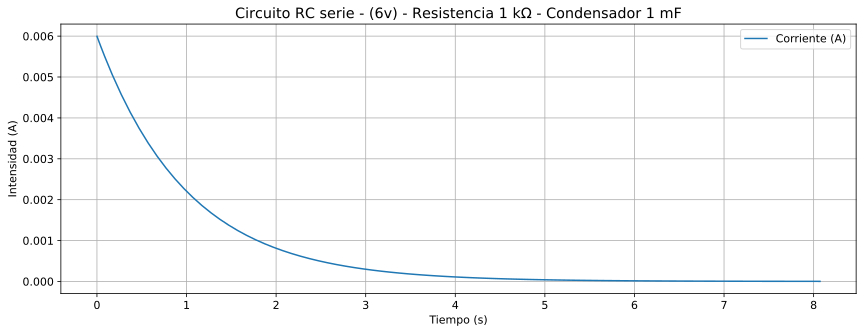

In [236]:
fig, ax = plot.subplots()
ax.set(xlabel='Tiempo (s)', 
    ylabel='Intensidad (A)', 
    title='Circuito RC serie - ($\mathrm{6v}$) - Resistencia $\mathrm{1\ k\Omega}$ - Condensador $\mathrm{1\ mF}$')
x = resultados['tran']['T']
y = resultados['tran']['I(V1)']
f = lambda x: -x if x < 0 else x
y = list(map(f, y))

ax.grid()
line, = ax.plot(x, y)
line.set_label('Corriente (A)')
plot.legend()
plot.tight_layout()
plot.show()
# Guardar figura en un archivo vectorial
fig.savefig(fig_directory + 'fig_current_RC.svg', transparent='true', format='svg')

 Se aprecia en la gráfica como la corriente inicial es de $\mathrm{6\ mA}$ aproximadamente y disminuye dibujando una curva que se aproxima asintóticamente a cero.

 Como ya hemos comentado anteriormente, los condensadores se oponen a los cambios bruscos de voltaje. Puesto que se han configurado las condiciones iniciales del condensador como sin carga, el inicio de la simulación es equivalente a encender la pila, estando previamente apagada y el condensador sin carga. Por lo que se da un cambio instantáneo de potencial en el circuito pasando de $\mathrm{0\ v}$ a $\mathrm{6\ v}$.

 Conforme se va cargando el condensador aumenta la impedancia (*resistencia*) de este, que al estar en serie con una resistencia (habitualmente llamada limitadora de corriente), la resistencia total aumenta con el tiempo, y la Ley de Ohm dice que si aumenta la resistencia la corriente disminuye, y esto es exactamente lo que vemos en la gráfica.

 #### Dibuja otra gráfica con el voltaje en el borne `V1`. ¿Por qué son *opuestas*? ¿Qué le ocurre al voltaje a medida que evoluciona el circuito en el tiempo?

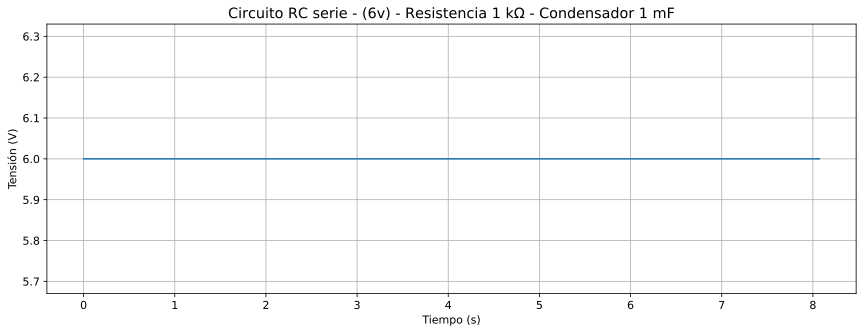

In [237]:
fig, ax = plot.subplots()
ax.set(xlabel='Tiempo (s)', 
    ylabel='Tensión (V)', 
    title='Circuito RC serie - ($\mathrm{6v}$) - Resistencia $\mathrm{1\ k\Omega}$ - Condensador $\mathrm{1\ mF}$')
x = resultados['tran']['T']
y = resultados['tran']['V1']
f = lambda x: -x if x < 0 else x
y = list(map(f, y))
ax.grid()
ax.plot(x, y)
plot.tight_layout()
plot.show()
# Guardar figura en un archivo vectorial
fig.savefig(fig_directory + 'fig_volt_RC.svg', transparent='true', format='svg')

 Las gráficas no son *opuestas*, y no deben serlo, puesto que `V1` es la salida de la pila, que en condiciones ideales es capaz de suministrar la corriente demandada y el voltaje se mantiene constante.

 ¿Como es esto posible? ¿Como puede variar la corriente y mantenerse la tensión constante? El motivo, es que la diferencia de potencial varía entre los extremos de la resistencia, pero no entre los extremos del circuito. Es decir, varia el voltaje entre los nodos 1 y 2 y entre los nodos 2 y 0, pero no entre los nodos 1 y 0, que es lo que la gráfica está mostrando.

 Dibujemos las gráficas del voltaje de la resistencia y del condensador para ver esto más claro. Y porque probablemente es a esto a lo que la pregunta se refiere.

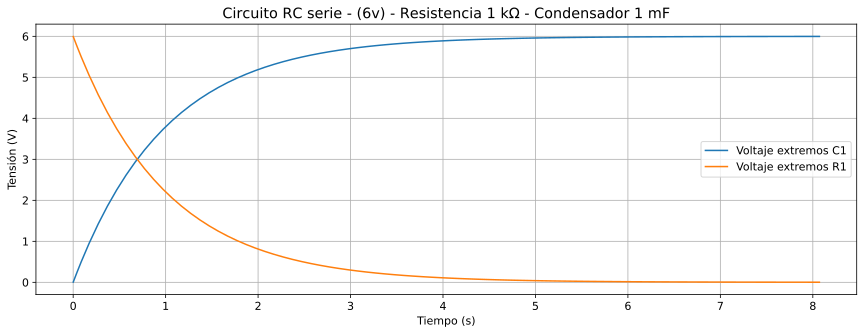

In [238]:
fig, ax = plot.subplots()
tiempo = resultados['tran']['T']
v1 = resultados['tran']['V1']
v_C1 = resultados['tran']['V2']
f = lambda a,b: a - b
v_R1 = list(map(f, v1, v_C1))

ax1 = plot.subplot(111)
line_C1, = ax1.plot(tiempo, v_C1)
line_C1.set_label('Voltaje extremos C1')

ax1.set(xlabel='Tiempo (s)', 
    ylabel='Tensión (V)', 
    title='Circuito RC serie - ($\mathrm{6v}$) - Resistencia $\mathrm{1\ k\Omega}$ - Condensador $\mathrm{1\ mF}$')

plot.legend()
plot.grid()
plot.tight_layout()
fig.savefig(fig_directory + 'fig_volts_c1_RC.svg', transparent='true', format='svg')

ax2 = plot.subplot(111)
line_R1, = ax2.plot(tiempo, v_R1)
line_R1.set_label('Voltaje extremos R1')

plot.legend()
plot.tight_layout()
ax1.grid()
ax2.grid()
# Guardar figura en un archivo vectorial
fig.savefig(fig_directory + 'fig_volts_r1_&_c1_RC.svg', transparent='true', format='svg')
plot.show()


 Aunque las gráficas del voltaje en los extremos de la resistencia y del condensador también son *opuestas*, no es esto lo que pregunta el enunciado. La comparación la debemos realizar entre la curva del voltaje del condensador y la curva de la corriente.

 ![](https://raw.githubusercontent.com/tikissmikiss/Laboratorio-LTspice/master/resource/figures/fig_current_RC.svg?sanitize=true)

 ![](https://raw.githubusercontent.com/tikissmikiss/Laboratorio-LTspice/master/resource/figures/fig_volts_c1_RC.svg?sanitize=true)

 El motivo por el que son opuestas, es porque de lo contrario no se cumpliría la Ley de Ohm ($\mathrm{V = R \cdot I}$). Si $\mathrm{R}$ es constante, y cambia $\mathrm{I}$, a la fuerza, tiene que cambiar $\mathrm{V}$. Pero la clave para comprenderlo está más bien en la resistencia *"limitadora de corriente"*, la cual, podemos estar seguros, tiene una resistencia constante.

 ¿Qué es lo que sucede? Puesto que `R1` tiene una resistencia constante y `C1` se opone a los cambios bruscos de tensión. A lo largo del tiempo cambia el voltaje que ocupa `C1`, y puesto que se debe de cumplir la Ley de Kirchhoff, al mantenerse constante el suministro de la pila, la suma de las tensiones de la resistencia y el condensador deben de sumar el voltaje de fuente. Esto hace que, por la Ley de Ohm, el voltaje en la resistencia también varíe (como se ve en su gráfica), al ser su resistencia constante provoca que varíe la corriente.

 ¿Por qué he llamado a la resistencia *"limitadora de corriente"*?

 No sería absurdo plantearse la siguiente cuestión. Si, la resistencia de `R1` es constante, el voltaje de la fuentes es constante, pero la corriente cambia en el tiempo, ¿Qué está pasando?, acaso, ¿el condensador tiene resistencia?, es más, ¿acaso la resistencia del condensador varía? Pues sí, además no pude ser de otro modo, no existe otra explicación que cumpla la Ley de Ohm. Pero no, en realidad los condensadores no tienen resistencia, o no exactamente, sino que la magnitud en la que se oponen al flujo de electrones está estrechamente ligada a la diferencia de potencial entre sus extremos. Es decir, cuando está ausente de carga (no hay diferencia de potencial en sus extremos) su resistencia, o mejor, llamémoslo por su nombre, su ***impedancia*** es $\mathrm{0\ \Omega}$.

 Para, para, para…, ¿cómo cero?, entonces, si su resistencia es 0, o mejor dicho, si su ***impedancia*** es 0. Si le aplicamos voltaje, según la Ley de Ohm…
 $$\mathrm{V=R\cdot I\ \rightarrow}\ I=\frac{\mathrm{V}}{\mathrm{R}}\mathrm{\ \rightarrow}\ I=\frac{\mathrm{V} }{\mathrm{0}}=\infty  $$
 ¿Es esto posible? Pues sí, así es, la corriente se iría a infinito. Esto es lo que en electrónica llamamos un *cortocircuito*. Por suerte, esto solo dura un instante, y aunque la fuente fuera capaz de suministrar tal cantidad de corriente (que no lo es), en cuanto el condensador empieza a cargarse, su impedancia aumenta rápidamente, y por suerte no agota todos los recursos energéticos que nos quedan.
 Este es el motivo por el que, en electrónica, a la resistencia que a menudo acompaña en serie al condensador, la llamamos *"limitadora de corriente"*, ya que garantiza que siempre haya una mínima resistencia y evite que el flujo de corriente sea infinito, y nos quedemos sin energía. Aunque hay alguna que otra posibilidad de que algo explote o se queme y nos libre de agotar la energía.

 Cuando hemos dibujado las gráficas más arriba, las hemos guardado cada una en un archivo de gráficos vectoriales escalables o SVG.

 ¡Veamos qué tal se ven!

 #### * Relación Corriente-Tiempo en un circuito RC serie
 ![Gráfico vectorial escalable - Relación Corriente-Tiempo en un circuito RC serie](https://raw.githubusercontent.com/tikissmikiss/Laboratorio-LTspice/master/python/figuras/fig_current_RC.svg?sanitize=true)

 #### * Relación Voltios-Tiempo para la resistencia y el condensador de un circuito RC serie
 ![Gráfico vectorial escalable - Relación Voltios-Tiempo para la resistencia y el condensador de un circuito RC serie](https://raw.githubusercontent.com/tikissmikiss/Laboratorio-LTspice/master/python/figuras/fig_volts_r1_&_c1_RC.svg?sanitize=true)

 #### * Relación Voltios-Tiempo en V1
 ![Gráfico vectorial escalable - Relación Voltios-Tiempo para la resistencia y el condensador de un circuito RC serie](https://raw.githubusercontent.com/tikissmikiss/Laboratorio-LTspice/master/python/figuras/fig_volt_RC.svg?sanitize=true)

 #### * Relación Voltios-Tiempo en el condensador de un circuito RC serie
 ![Gráfico vectorial escalable - Relación Voltios-Tiempo para la resistencia y el condensador de un circuito RC serie](https://raw.githubusercontent.com/tikissmikiss/Laboratorio-LTspice/master/python/figuras/fig_volts_c1_RC.svg?sanitize=true)

 #### ¿Qué valores devuelve el análisis de tipo `.op`?

 El análisis `.op` devuelve lo siguiente:

In [239]:
print(resultados['op'])

OP simulation results for '* carga condensador'(netlist files\condensador_en_continua.ckt).
Run on 2020-12-21 22:25:30, data file None.
Variable    Units      Value    Error    %
----------  -------  -------  -------  ---
V1          V              6   -6e-12    0
V2          V              6   -6e-12    0
I(V1)       A              0    0        0



 Está mostrando la situación del circuito tras haberse estabilizado después de aplicar la tensión. Esto es con el condensador en su máxima carga posibles para el potencial suministrado.

 Como podemos ver arriba, la curva de la carga del condensador se pega asintóticamente a $\mathrm{6\ v}$. Y la curva de la corriente se pega asintóticamente a $\mathrm{0\ A}$. Y esto solo puede suceder porque la impedancia del condensador ha aumentado hasta el punto de ser tan elevada que casi se interrumpe el flujo eléctrico, aunque esto nunca llega a suceder.

 ## Carrera de condensadores

 Ahora tenemos un circuito con dos condensadores en paralelo:

 ![](https://raw.githubusercontent.com/pammacdotnet/spicelab/master/condensadores%20en%20paralelo.svg?sanitize=true)

 #### **Pregunta:**

 > Crea el netlist de este circuito e identifica qué condensador se satura primero. Dibuja la evolución de la intensidad en ambas ramas de manera simultánea. [Aquí](https://matplotlib.org/gallery/api/two_scales.html) tienes un ejemplo de cómo se hace esto en Matplotlib. Recuerda que para que Ahkab nos devuelva la corriente en una rama, debe de estar presente una pila. Si es necesario, inserta pilas virtuales de valor nulo (cero voltios), tal y como hemos comentado antes. Grafica también los voltajes (en otra gráfica, pero que aparezcan juntos).

 #### **Respuesta:**

 Ambos se cargarán al mismo tiempo, debido a que están en paralelo entre sí y en serie con una resistencia común, lo que va a provocar que ambas tenga la misma tensión.# %%

In [240]:
%%writefile "files\carrera_de_condensadores.ckt"
* Carga condensador
v0 1 0 type=vdc vdc=10
r1 0 2 3.3k
c1 2 3 47u ic=0
v1dummy 3 1 type=vdc vdc=0
c2 2 4 22u ic=0
v2dummy 4 1 type=vdc vdc=0
.tran tstep=0.01 tstart=6.5 tstop=7.5 uic=0
.end

Writing files\carrera_de_condensadores.ckt


 ### Procesamos el circuito con `Ahkab` y extraemos los datos.

In [241]:
# Procesar circuito
circuito_y_análisis = ahkab.netlist_parser.parse_circuit("files\carrera_de_condensadores.ckt")
# Separar datos netlist y simulaciones
netlist = circuito_y_análisis[0]
análisis_en_netlist = circuito_y_análisis[1]
# Extraer datos de simulaciones
lista_de_análisis = ahkab.netlist_parser.parse_analysis(netlist, análisis_en_netlist)
# Establecer condiciones óptimas para los análisis `.dc` y/o `.tran` si lo hay.
for análisis in [d for i, d in enumerate(lista_de_análisis) if "dc" in d.values() or "tran" in d.values()]:
    análisis['outfile'] = files_directory + "simulación_" + análisis['type'] + ".tsv"

  Ejecutamos la simulación

In [242]:
resultados = ahkab.run(netlist, lista_de_análisis)

Starting transient analysis: 
Selected method: TRAP
Solving...  done.
Average time step: 0.00900901


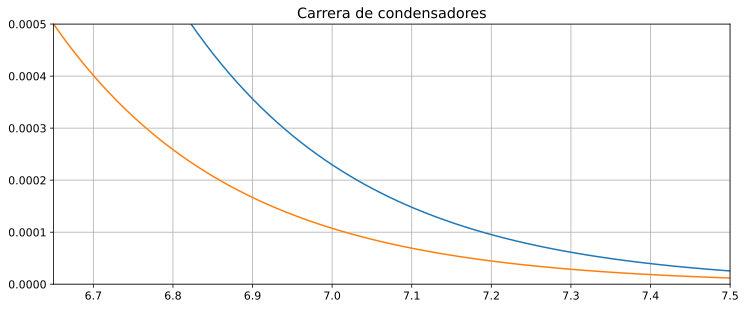

In [243]:
figura = plt.figure()
plt.title("Carrera de condensadores")
plt.xlim(6.65, 7.5)
plt.ylim(0.0, 0.0005)
plt.grid()
plt.plot(list(map(lambda x: -x if x < 0 else x, resultados['tran']['T'])), 
    list(map(lambda x: -x if x < 0 else x, resultados['tran']['I(V1DUMMY)'])), 
    label="Intensidad en C1")
plt.plot(list(map(lambda x: -x if x < 0 else x, resultados['tran']['T'])), 
    list(map(lambda x: -x if x < 0 else x, resultados['tran']['I(V2DUMMY)'])), 
    label="Intensidad en C2")

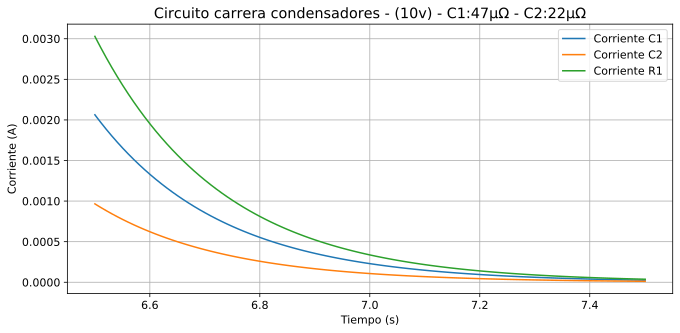

In [244]:
tiempo = resultados['tran']['T']
f = lambda x: -x if x < 0 else x
i_C1 = resultados['tran']['I(V1DUMMY)']
i_C1 = list(map(f, i_C1))
i_C2 = resultados['tran']['I(V2DUMMY)']
i_C2 = list(map(f, i_C2))
i_R1 = resultados['tran']['I(V0)']
i_R1 = list(map(f, i_R1))

plot.rcParams['figure.figsize'] = [6.4*1.5, 4.8]
plot.rcParams['font.size'] = 12
fig, ax = plot.subplots()
plot.title('Circuito carrera condensadores - ($\mathrm{10v}$) - C1:$\mathrm{47\mu\Omega}$ - C2:$\mathrm{22\mu\Omega}$')
ax.set(xlabel='Tiempo (s)', ylabel='Corriente (A)')
line_iC1, = ax.plot(tiempo, i_C1)
line_iC2, = ax.plot(tiempo, i_C2)
line_iR1, = ax.plot(tiempo, i_R1)
line_iC1.set_label('Corriente C1')
line_iC2.set_label('Corriente C2')
line_iR1.set_label('Corriente R1')
plot.legend()
plot.grid(True)
plot.tight_layout()
plot.show()

 Se puede observar la corriente de ambos condensadores y la de la resistencia, que es la misma que la total del circuito, aunque su bajada es diferente, se acercan a cero prácticamente a la vez.

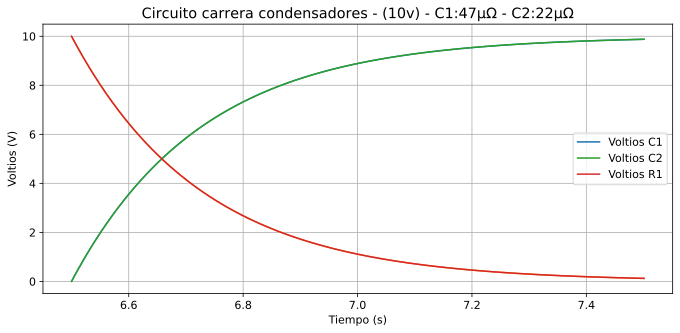

In [245]:
tiempo = resultados['tran']['T']
v_R1 = resultados['tran']['V2']
v_C1 = resultados['tran']['V3']
v_C2 = resultados['tran']['V4']
f = lambda a, b: a - b
v_C1 = list(map(f, v_C1, v_R1))
v_C2 = list(map(f, v_C2, v_R1))

fig, ax = plot.subplots()
plot.title('Circuito carrera condensadores - ($\mathrm{10v}$) - C1:$\mathrm{47\mu\Omega}$ - C2:$\mathrm{22\mu\Omega}$')
ax.set(xlabel='Tiempo (s)', ylabel='Voltios (V)')
ax.grid(True)

line_vC1, = ax.plot(tiempo, v_C1)
line_vR1, = ax.plot(tiempo, v_R1)
line_vC2, = ax.plot(tiempo, v_C2)
line_vR1, = ax.plot(tiempo, v_R1)
line_vC1.set_label('Voltios C1')
line_vC1.set_c('tab:blue')
line_vR1.set_label('Voltios R1')
line_vR1.set_c('tab:red')
line_vC2.set_label('Voltios C2')
line_vC2.set_c('tab:green')
line_vR1.set_label('Voltios R1')
line_vR1.set_c('tab:red')

plot.legend()
plot.tight_layout()

 Puesto que el voltaje de la fuente no cambia, se reparten la diferencia de potencial entre la resistencia y los dos condensadores.

 #### Todas juntas.

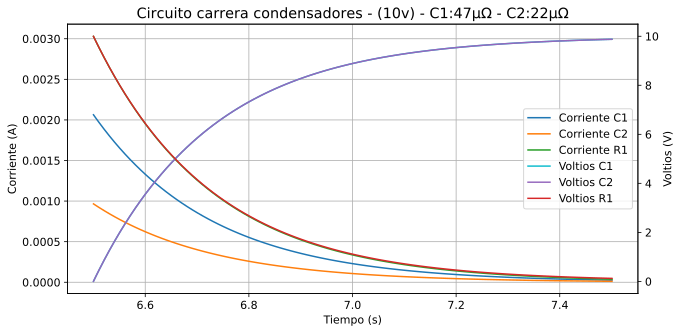

In [246]:
fig, ax1 = plot.subplots()
ax2 = ax1.twinx()  
plot.title('Circuito carrera condensadores - ($\mathrm{10v}$) - C1:$\mathrm{47\mu\Omega}$ - C2:$\mathrm{22\mu\Omega}$') 
ax1.set_xlabel('Tiempo (s)') 
ax1.set_ylabel('Corriente (A)')
ax2.set_ylabel('Voltios (V)')
ax1.tick_params(axis='y')#, labelcolor=color)
ax2.tick_params(axis='y')
ax1.grid(True)
line_iC1, = ax1.plot(tiempo, i_C1)
line_iC2, = ax1.plot(tiempo, i_C2)
line_iR1, = ax1.plot(tiempo, i_R1)
line_vC1, = ax2.plot(tiempo, v_C1)
line_vC2, = ax2.plot(tiempo, v_C2)
line_vR1, = ax2.plot(tiempo, v_R1)
line_iC1.set_c('tab:blue')
line_iC2.set_c('tab:orange')
line_iR1.set_c('tab:green')
line_vC1.set_c('tab:cyan')
line_vC2.set_c('tab:purple')
line_vR1.set_c('tab:red')

plot.legend(
    (line_iC1, line_iC2, line_iR1, line_vC1, line_vC2, line_vR1, ), 
    ("Corriente C1", "Corriente C2", "Corriente R1", "Voltios C1", "Voltios C2", "Voltios R1"))
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

 ### **Ejercicio premium:**

 Repite la simulación con LTspice (invocándolo como comando externo, leyendo los datos de un fichero `.raw` y volviendo a graficar con Matplotlib.

 ### Resolución del mismo circuito con LTspice

 Vamos a adaptar el netlist para que sea compatible con LTspice.


 El efecto de la configuración del análisis `.tran` difiere bastante entre LTspice y Ahkab.
 En Ahkab tenemos puesto:
 ````Ahkab
 .tran tstep=0.01 tstart=6.5 tstop=7.5 uic=0
 ````
 Esta configuración mantiene el circuito en reposo hasta que se alcanza `tstart` (6.5 seg.). Un instante antes se activa la pila y en el instante siguiente se inicia al mismo tiempo la simulación y las mediciones del análisis.

 La expresión equivalente en LTspice sería la siguiente:
 ````LTspice
 .tran 0.01 7.5 6.5 uic
 ````
 Pero el efecto que tiene es totalmente diferente. En este caso LTspice, inicia la simulación en el instante 0, pero no comienza a tomar medidas hasta los 6.5 seg. y deja de tomar medias 1 seg. después de la primera medición. Por lo que para cuando se empieza muestrear la señal los condensadores ya están cargados.

 Para simular un escenario similar al de la simulación con `Ahkab`, usaremos la opción PWL que permite establecer un voltaje concreto en el instante deseado.


 ¿Como funciona PWL?

 $\mathrm{PWL([T_1\ V_1]\ [T_2\ V_3]\ ...\ [T_n\ V_n]\ )}$

 Se ponen números separados por espacios, que están relacionados por parejas, de modo que las posiciones impares representan un instante en el tiempo, y las posiciones pares el voltaje al que se pondrá la pila en ese instante.

 Nuestra configuración va a estar construida por la combinación de PWL con el análisis `.tran`.

 * PWL: Esta configuración mantendrá la pila sin tensión hasta los 6.5 segundos, y en la décima de segundo siguiente se pondrá a 10 v.

 ````PWL(6.5 0 6.51 10)````

 * .tran: Esta configuración afectara de modo que, no se van a realizar mediciones hasta una décima de segundo antes de que se active la pila, y tomará medias cada décima de segundo hasta el segundo 8.

 ````.tran 0 8 6.4 0.01 uic````

In [247]:
%%writefile "files\carrera_de_condensadores.net"
* Carga condensador
v0 1 0 PWL(6.5 0 6.51 10)
r1 2 0 3.3k
c1 1 2 47u
c2 1 2 22u 
.tran 0 8 6.4 0.01 uic
.end

Writing files\carrera_de_condensadores.net


 Ejecutamos LTspice pasando al ejecutable el archivo que acabamos de crear como parámetro.

In [248]:
# lts "files\carrera_de_condensadores.net"
if platform.system() == "Darwin":
    get_ipython().system('/Applications/LTspice.app/Contents/MacOS/LTspice -ascii -b files/carrera_de_condensadores.net')
if platform.system() == "Windows":
    get_ipython().system('"C:\\Program Files\\LTC\\LTspiceXVII\\XVIIx64.exe" -ascii -b files\\carrera_de_condensadores.net')

 Veamos el contenido del archivo, `.log`.

 ## Contenido del `.log`:

In [249]:
get_ipython().run_line_magic('pycat', 'files\carrera_de_condensadores.log')

 Ahora extraemos los datos del archivo `.raw`.

In [250]:
l = ltspice.Ltspice("files\carrera_de_condensadores.raw")
l.parse()

tiempo = l.get_time()
i_C1 = l.get_data('I(C1)')
i_C2 = l.get_data('I(C2)')
i_R1 = l.get_data('I(R1)')
v_R1 = l.get_data('V(2)')
vcc = l.get_data('V(1)')
v_Cs = l.get_data('V(1)')
f = lambda a, b: a - b
v_Cs = list(map(f, v_Cs, v_R1))

 Dibujamos las gráficas con los datos obtenidos con LTspice.

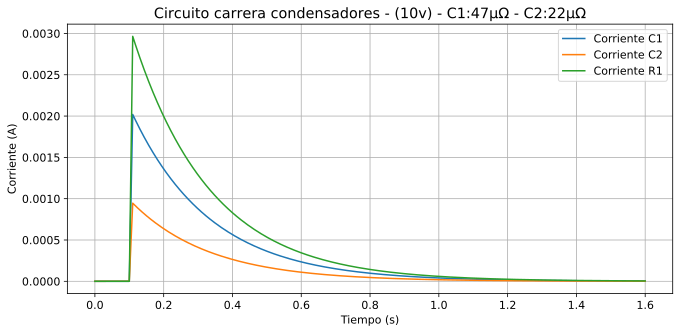

In [251]:
# plot.rcParams['figure.figsize'] = [6.4*1.9, 4.8]
plot.rcParams['font.size'] = 12

fig, ax = plot.subplots()
plot.title('Circuito carrera condensadores - ($\mathrm{10v}$) - C1:$\mathrm{47\mu\Omega}$ - C2:$\mathrm{22\mu\Omega}$')
ax.set(xlabel='Tiempo (s)', ylabel='Corriente (A)')

line_iC1, = ax.plot(tiempo, i_C1)
line_iC1.set_label('Corriente C1')

line_iC2, = ax.plot(tiempo, i_C2)
line_iC2.set_label('Corriente C2')

line_iR1, = ax.plot(tiempo, i_R1)
line_iR1.set_label('Corriente R1')

plot.legend()
plot.grid(True)
plot.tight_layout()
plot.show()

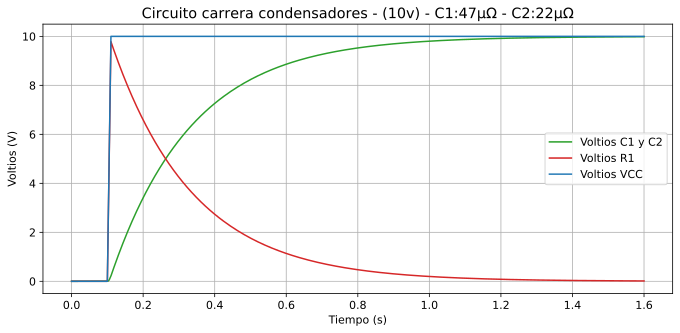

In [252]:
# plot.rcParams['figure.figsize'] = [6.4*1.9, 4.8]
plot.rcParams['font.size'] = 12

fig, ax = plot.subplots()
plot.title('Circuito carrera condensadores - ($\mathrm{10v}$) - C1:$\mathrm{47\mu\Omega}$ - C2:$\mathrm{22\mu\Omega}$')
ax.set(xlabel='Tiempo (s)', ylabel='Voltios (V)')

line_vC2, = ax.plot(tiempo, v_Cs)
line_vC2.set_label('Voltios C1 y C2')
line_vC2.set_c('tab:green')

line_vR1, = ax.plot(tiempo, v_R1)
line_vR1.set_label('Voltios R1')
line_vR1.set_c('tab:red')

line_vC1, = ax.plot(tiempo, vcc)
line_vC1.set_label('Voltios VCC')
line_vC1.set_c('tab:blue')

ax.grid(True)
plot.legend()
plot.tight_layout()
# plt.savefig("test.svg", format="svg")
plot.rcParams['figure.figsize'] = [6.4*1.9, 4.8]
# {'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'}

 ## Circuitos en corriente alterna

 ### ** Ejercicio:**

 Simula este circuito con LTspice y representa el voltaje y la intensidad en función del tiempo. Traduce este ejercicio a la versión Spice de Akhab y haz la misma representación. Ahkab utiliza otra sintaxis para expresar la corriente alterna. Esta está descrita en la [documentación](https://ahkab.readthedocs.io/en/latest/help/Netlist-Syntax.html#id24).
 ```* Circuito en corriente alterna
 v1 1 0 sin(0 120 60 0 0)
 r1 0 1 10k
 .tran 1
 .end
 ```

 ### ** Solución:**

 ![](https://raw.githubusercontent.com/tikissmikiss/Laboratorio-LTspice/master/resource/Circuito_alterna_lab_fisica.svg?sanitize=true)

 Se simula un circuito de corriente alterna usando un generador de onda sinusoidal configurado con un voltaje de pico de $\mathrm{120\ v}$, es decir, $V_{pp}=\mathrm{240\ v}$, y una frecuencia de $\mathrm{60\ Hz}$, conectado a una carga de $\mathrm{10\ k\Omega}$

In [253]:
%%writefile "files\corriente_alterna.net"
* Circuito en corriente alterna
v1 1 0 sin(0 120 60 0 0)
r1 0 1 10k
.tran 1
.end

Writing files\corriente_alterna.net


 Ejecutamos LTspice con el netlist como parámetro para generar los archivos `.log` y `.raw`.

In [254]:
# lts "files\corriente_alterna.net"
if platform.system() == "Darwin":
    get_ipython().system('/Applications/LTspice.app/Contents/MacOS/LTspice -ascii -b files/corriente_alterna.net')
if platform.system() == "Windows":
    get_ipython().system('"C:\\Program Files\\LTC\\LTspiceXVII\\XVIIx64.exe" -ascii -b files\\corriente_alterna.net')

 Ahora extraemos los datos relativos al tiempo, la corriente y tensión del archivo `.raw` y los almacenamos en vectores diferentes.

In [255]:
l = ltspice.Ltspice("files\corriente_alterna.raw")
l.parse()

tiempo = l.get_time()
vac = l.get_data('V(1)')
i_R1 = l.get_data('I(R1)')
nSvg=0

 Representamos los datos obtenidos con LTspice en una misma gráfica.

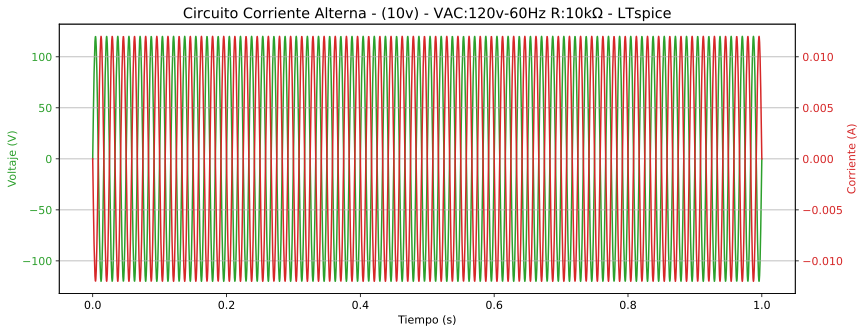

In [256]:
plot.rcParams['figure.figsize'] = [6.4*1.9, 4.8]
plot.rcParams['font.size'] = 12
rojo='tab:red'
verde='tab:green'

fig, ax_V = plot.subplots()
plot.title('Circuito Corriente Alterna - ($\mathrm{10v}$) - VAC:$\mathrm{120v}$-$\mathrm{60Hz}$ R:$\mathrm{10k\Omega}$ - LTspice')
ax_I = ax_V.twinx()  

ax_V.tick_params(axis='y', labelcolor=verde)
ax_I.tick_params(axis='y', labelcolor=rojo)

ax_V.set_xlabel('Tiempo (s)')
ax_V.set_ylabel('Voltaje (V)', color=verde)
ax_I.set_ylabel('Corriente (A)', color=rojo)

line_V, = ax_V.plot(tiempo, vac)
line_V.set_label('Corriente R1')
line_V.set_c(verde)

line_I, = ax_I.plot(tiempo, i_R1)
line_I.set_label('Voltaje VAC')
line_I.set_c(rojo)

plot.grid(True)
plot.tight_layout()
nSvg += 1
fig.savefig(fig_directory + 'alterna' + str(nSvg) + '.svg', transparent='true', format='svg')

 Hemos representado la señal en el transcurso de 1 segundo y es difícil de apreciar la señal con claridad.
 Vamos a representar usando el mismo espacio, tres ciclos completos. Puesto que la onda generada es de $\mathrm{60\ Hz}$, tenemos que captura tres veces la sexagésima parte de un segundo, es decir, $\mathrm{\frac{1}{20}\ s}$.

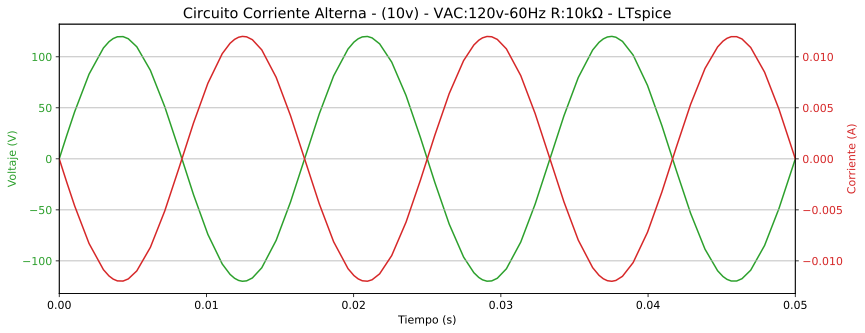

In [257]:
plot.rcParams['figure.figsize'] = [6.4*1.9, 4.8]
plot.rcParams['font.size'] = 12
rojo='tab:red'
verde='tab:green'

fig, ax_V = plot.subplots()
ax_V.set_xlim(0, 1/20)
plot.title('Circuito Corriente Alterna - ($\mathrm{10v}$) - VAC:$\mathrm{120v}$-$\mathrm{60Hz}$ R:$\mathrm{10k\Omega}$ - LTspice')
ax_I = ax_V.twinx()  

ax_V.tick_params(axis='y', labelcolor=verde)
ax_I.tick_params(axis='y', labelcolor=rojo)

ax_V.set_xlabel('Tiempo (s)')
ax_V.set_ylabel('Voltaje (V)', color=verde)
ax_I.set_ylabel('Corriente (A)', color=rojo)

line_V, = ax_V.plot(tiempo, vac)
line_V.set_label('Corriente R1')
line_V.set_c(verde)

line_I, = ax_I.plot(tiempo, i_R1)
line_I.set_label('Voltaje VAC')
line_I.set_c(rojo)

plot.grid(True)
plot.tight_layout()
nSvg += 1
fig.savefig(fig_directory + 'alterna' + str(nSvg) + '.svg', transparent='true', format='svg')

 Vaya,... Parece que se ha perdido algo de calidad en la representación y la onda no se ve todo lo suavizada que debería. Esto es debido a que hemos pedido a LTspice que muestre la señal durante un segundo, por lo que ha adaptado el sampling rate a ese tiempo. Ahora, al dibujar solo 0.05 segundos, el número de muestras contenidas en ese tiempo es relativamente bajo, y por eso podemos apreciar en el gráfico vectorial los vectores rectos que dibujan la curva, apreciándose los vértices donde confluyen dos vectores.

   Aunque la calidad es podría ser suficiente para analizar el resultado, estamos por aprender, así que vamos a volver a repetir la simulación pero esta vez le pediremos a LTspice que concentre todas las muestras en 0.05 segundos.

 Veamos el resultado.

In [258]:
%%writefile "files\corriente_alterna.net"
* Circuito en corriente alterna
v1 1 0 sin(0 120 60 0 0)
r1 0 1 10k
.tran 0.05
.end

Overwriting files\corriente_alterna.net


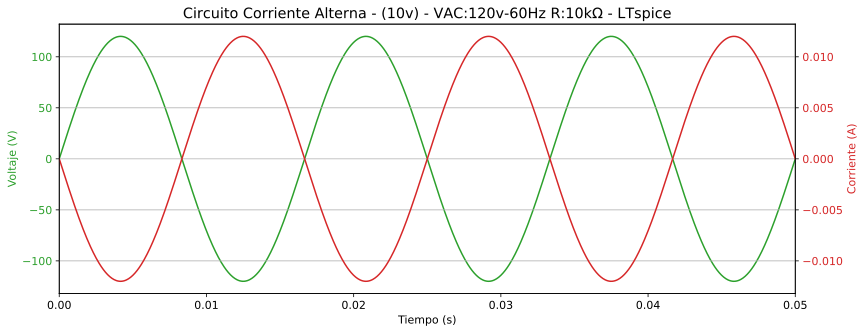

In [259]:
# lts "files\corriente_alterna.net"
if platform.system() == "Darwin":
    get_ipython().system('/Applications/LTspice.app/Contents/MacOS/LTspice -ascii -b files/corriente_alterna.net')
if platform.system() == "Windows":
    get_ipython().system('"C:\\Program Files\\LTC\\LTspiceXVII\\XVIIx64.exe" -ascii -b files\\corriente_alterna.net')

l = ltspice.Ltspice("files\corriente_alterna.raw")
l.parse()

tiempo = l.get_time()
vac = l.get_data('V(1)')
i_R1 = l.get_data('I(R1)')

plot.rcParams['figure.figsize'] = [6.4*1.9, 4.8]
plot.rcParams['font.size'] = 12
rojo='tab:red'
verde='tab:green'

fig, ax_V = plot.subplots()
ax_V.set_xlim(0, 1/20)
plot.title('Circuito Corriente Alterna - ($\mathrm{10v}$) - VAC:$\mathrm{120v}$-$\mathrm{60Hz}$ R:$\mathrm{10k\Omega}$ - LTspice')
ax_I = ax_V.twinx()  

ax_V.tick_params(axis='y', labelcolor=verde)
ax_I.tick_params(axis='y', labelcolor=rojo)

ax_V.set_xlabel('Tiempo (s)')
ax_V.set_ylabel('Voltaje (V)', color=verde)
ax_I.set_ylabel('Corriente (A)', color=rojo)

line_V, = ax_V.plot(tiempo, vac)
line_V.set_label('Corriente R1')
line_V.set_c(verde)

line_I, = ax_I.plot(tiempo, i_R1)
line_I.set_label('Voltaje VAC')
line_I.set_c(rojo)

# plot.legend()
plot.grid(True)
plot.tight_layout()
nSvg += 1
fig.savefig(fig_directory + 'alterna' + str(nSvg) + '.svg', transparent='true', format='svg')

 Ahora sí, otra cosa es esto. Como podemos apreciar en la gráfica, el voltaje y la corriente evolucionan con una proporcionalidad inversa de 10000:1, justamente el número de ohmios que tiene una resistencia de $\mathrm{10\ k\Omega}$ como la de nuestro circuito. ¿Qué porqué coincide?, pues por la Ley de Ohm, para $\mathrm{10\ k\Omega}$ hacen falta $\mathrm{10\ kV}$ para tener $\mathrm{1\ A}$.

 ### Ahora realicemos la simulación con Ahkab
 Lo primero es adaptar el netlist

In [260]:
%%writefile "files\corriente_alterna.ckt"
* Circuito alterna
V1 1 0 type=sin vo=0 va=120 freq=60
R1 0 1 10k
.tran tstep=0.0001 tstart=0 tstop=0.05
.end

Writing files\corriente_alterna.ckt


 ### Procesamos el circuito con `Ahkab` y extraemos los datos.

In [261]:
# Procesar circuito
circuito_y_análisis = ahkab.netlist_parser.parse_circuit("files\corriente_alterna.ckt")
# Separar datos netlist y simulaciones
netlist = circuito_y_análisis[0]
análisis_en_netlist = circuito_y_análisis[1]
# Extraer datos de simulaciones
lista_de_análisis = ahkab.netlist_parser.parse_analysis(netlist, análisis_en_netlist)
# Establecer condiciones óptimas para los análisis `.dc` y/o `.tran` si lo hay.
for análisis in [d for i, d in enumerate(lista_de_análisis) if "dc" in d.values() or "tran" in d.values()]:
    análisis['outfile'] = files_directory + "simulación_" + análisis['type'] + ".tsv"

  Ejecutamos la simulación

In [262]:
resultados = ahkab.run(netlist, lista_de_análisis)

Starting transient analysis: 
Selected method: TRAP
Solving...  done.
Average time step: 9.86193e-05


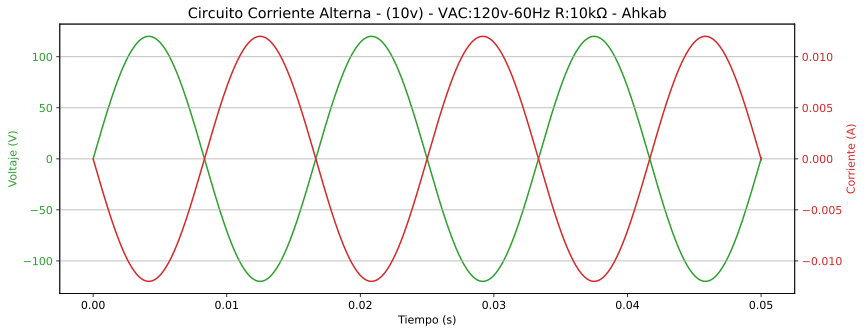

In [263]:
tiempo = resultados['tran']['T']
vac = resultados['tran']['V1']
f = lambda x: -x if x < 0 else x
i_R1 = resultados['tran']['I(V1)']
# i_R1 = list(map(f, i_R1))

plot.rcParams['figure.figsize'] = [6.4*1.9, 4.8]
plot.rcParams['font.size'] = 12
rojo='tab:red'
verde='tab:green'

fig, ax_V = plot.subplots()
# ax_V.set_xlim(0, 1/20)
plot.title('Circuito Corriente Alterna - ($\mathrm{10v}$) - VAC:$\mathrm{120v}$-$\mathrm{60Hz}$ R:$\mathrm{10k\Omega}$ - Ahkab')
ax_I = ax_V.twinx()  

ax_V.tick_params(axis='y', labelcolor=verde)
ax_I.tick_params(axis='y', labelcolor=rojo)

ax_V.set_xlabel('Tiempo (s)')
ax_V.set_ylabel('Voltaje (V)', color=verde)
ax_I.set_ylabel('Corriente (A)', color=rojo)

line_V, = ax_V.plot(tiempo, vac)
line_V.set_label('Corriente R1')
line_V.set_c(verde)

line_I, = ax_I.plot(tiempo, i_R1)
line_I.set_label('Voltaje VAC')
line_I.set_c(rojo)

plot.grid(True)
plot.tight_layout()
nSvg += 1
fig.savefig(fig_directory + 'alterna' + str(nSvg) + '.svg', transparent='true', format='svg')